# Pipeline Exploration
This project workflow is comprised of distinct stages including: 

1. Universe Definition
2. Alpha Discovery

In [3]:
import pyfolio as pf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
load_data = False
if load_data:
    print ('ready to load data from quandl')

In [5]:
import warnings
warnings.filterwarnings("ignore")
import vlc
from time import sleep

In [6]:
import alphalens as al

In [7]:
import quandl
import quantstats as qs
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
from sklearn import preprocessing
import pytz
import itertools

In [8]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [9]:
import risk_model
import factorize
import account
import utils_s
import feature_weights

In [10]:
import zipfile
import os

In [11]:
quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'

# 1 - Parameters

## 1 - 1 - Date parameters

In [12]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))
fivedays_ago = tod - datetime.timedelta(days=5)
#fivedays_ago = datetime.datetime.strptime(str(fivedays_ago), '%Y-%m-%d').strftime("%Y-%m-%d")
print ('5 days ago: {}'.format(fivedays_ago))
year_ago = tod - datetime.timedelta(days=365)
#t_ago = datetime.datetime.strptime(str(t_ago), '%Y-%m-%d').strftime("%Y-%m-%d")
print ('12 months ago: {}'.format(year_ago))

current date: 2020-07-06
5 days ago: 2020-07-01
12 months ago: 2019-07-07


In [13]:
# SF1
three_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(three_years,month,day)
print ('SF1 starting date: {}'.format(start_f))

SF1 starting date: 2016-7-6


In [14]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP and Daily starting date: {}'.format(start_sep))

SEP and Daily starting date: 2017-7-6


## 1 - 2 - Universe filteration parameters

In [15]:
filteration_number  = 200
smoothing_universe_period = 100

## 1 - 3 - Slicing date parameter

In [16]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-7-6


## 1 - 4 - Multi factor analysis parameters

In [17]:
rebalance_period = 5
combined_periods = (3,5,10)

In [18]:
# Risk analysis
factor_exposures = 13

## 1 - 5 - Optimizer parameters

In [19]:
lambda_reg = 0.5
risk_cap = 0.05

## 1 - 6 - Sectors to drop

In [20]:
sec_to_drop = [ 
                'Basic Materials',
                'Communication Services',
                'Energy'
              ]

In [21]:
drop_long_sec = []
drop_short_sec = []

## 1 - 7 - MarketCap categories

In [22]:
cap_select = ['6 - Mega', '5 - Large', '4 - Mid']

## 1 - 8 - Factors

In [23]:
smoothed_value = 5

In [24]:
selected_indicators = ['cashneq']

In [25]:
momentum_in = {'momentum_252d':252}

In [26]:
sma_in = {'sma200':200}

In [27]:
daily_in = {'marketcap':100, 'evebitda':100}

In [28]:
over_in = {'overnight_sentiment_5d':5}

In [29]:
direction_in = {'direction_100d':100}

In [30]:
sent_in = {'sentiment_100d':100}

## 1 - 9 - Quantiles

In [31]:
qunatile_portions = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5
                     ,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]

In [32]:
qunatile_to_analysis = [1,(len(qunatile_portions)-1)]

# 2 - Data processing

## 2 - 1 - Get  META data

In [33]:
meta = quandl.get_table('SHARADAR/TICKERS', table='SF1',paginate=True)
meta.set_index('ticker',inplace=True, drop=True)

## 2 - 1 - 1 - First universe filteration

In [34]:
meta_ex = meta[(meta['exchange'] == 'NYSE') ^ (meta['exchange'] == 'NASDAQ')]
cap = []
for i in cap_select:
    cap.append(list(meta_ex[(meta_ex['scalemarketcap'] == i)].index))
meta_ex_sc = meta_ex.loc[list(itertools.chain.from_iterable(cap))]    
meta_ex_sc_cu = meta_ex_sc[(meta_ex_sc['currency'] == 'USD') & (meta_ex_sc['isdelisted'] == 'N')]

In [35]:
u1 = list(meta_ex_sc_cu.index)

In [36]:
print ('{} companies selected in first filteration'.format(len(u1)))

1991 companies selected in first filteration


## 2 - 2 - Get two years data for SEP

In [37]:
if load_data:
    quandl.export_table('SHARADAR/SEP',
                        ticker=u1, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename = 'ohlcv.zip')

In [38]:
with zipfile.ZipFile('ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


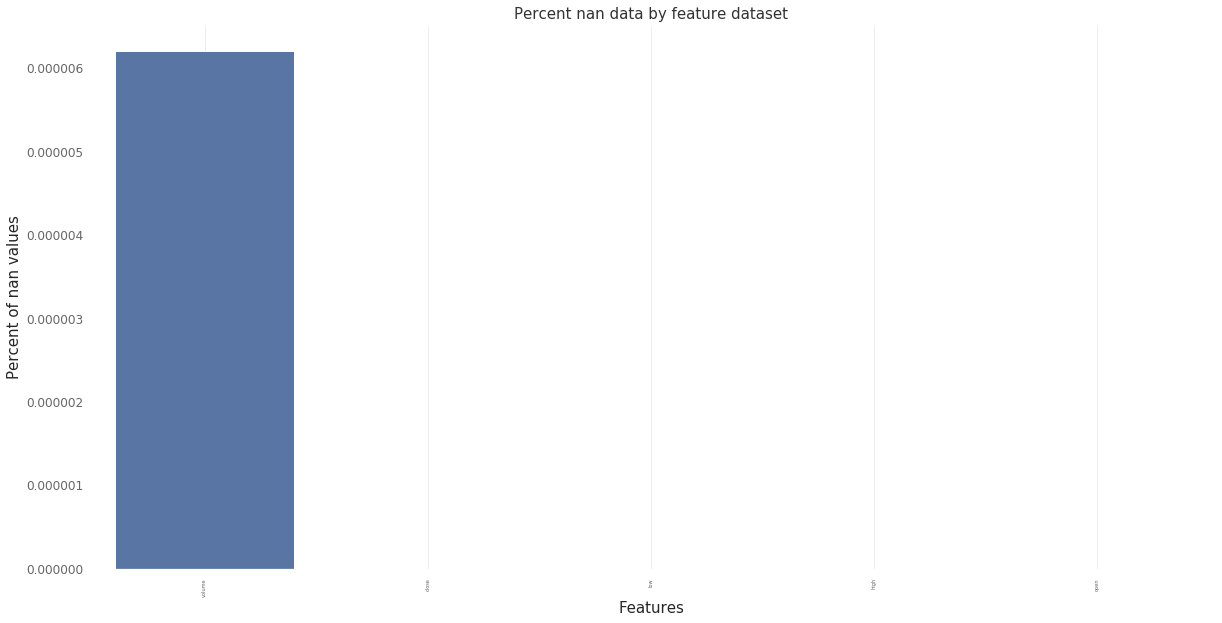

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [39]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

### 2 - 2 - 1 - Second universe filteration using Market Capitalization 

In [40]:
def dollar_volume_universe(tickers_num, ohlcv, sma_period):
    
    ohlcv['dollar_volume'] = ohlcv['close']*ohlcv['volume']
    dollar_vol = ohlcv['dollar_volume'].unstack('ticker')
    sma = pd.DataFrame(index = dollar_vol.index)
    try:
        for tick in dollar_vol.columns:
            sma[tick] = talib.SMA(dollar_vol[tick].values, timeperiod=sma_period)
    except:
        pass
    
    last = sma.iloc[-1,:]
    dol = pd.DataFrame(data = last.values,index = last.index, columns = ['dv'])
    dol.dropna(inplace = True)
    
    return list(dol.sort_values(by='dv', ascending=False).iloc[:tickers_num].index)    

In [41]:
universe = dollar_volume_universe(tickers_num = filteration_number, ohlcv = ohlcv, sma_period = smoothing_universe_period)

In [42]:
print ('{} companies selected out of {} for second filteration'.format(len(universe),len(u1)))

200 companies selected out of 1991 for second filteration


#### Sector filteration

In [43]:
universe_sectors = pd.DataFrame(index=universe, columns=['sectors'])
for i in universe:
    universe_sectors.loc[i] = meta_ex_sc_cu.loc[i]['sector']
    
    for sec in sec_to_drop:
        if meta_ex_sc_cu.loc[i]['sector'] == sec:
            universe_sectors.drop(i, axis=0,inplace=True)

In [44]:
universe = list(universe_sectors.index)

In [45]:
print ('{} companies selected after sector drop out of {} for second filteration'.format(len(universe),len(u1)))

183 companies selected after sector drop out of 1991 for second filteration


## 2 - 3 - Get three years data for SF1

In [46]:
if load_data:
    #qopts={"columns":ind}
    quandl.export_table('SHARADAR/SF1',
                        ticker=universe, 
                        dimension = 'MRQ', 
                        calendardate={'gte':start_f,'lte':str(tod)}, 
                        filename='fundamental.zip')

In [47]:
with zipfile.ZipFile('fundamental.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SF1':
        sf1 = pd.read_csv(item)
        sf1 = sf1.set_index(['calendardate', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sf1.drop(['datekey','reportperiod','lastupdated','dimension'],axis=1,inplace=True)
        os.remove(item)  

In [48]:
print ('the following tickers are not loaded in sf1:\n {}'.format(list(sf1.index.levels[1] ^ universe)))
print ('{} securities loaded out of {}'.format(len(sf1.index.levels[1]), len(universe)))

the following tickers are not loaded in sf1:
 []
183 securities loaded out of 183


### 2 - 3 - 1 - Cleaning data

cleaning data
columns are clean


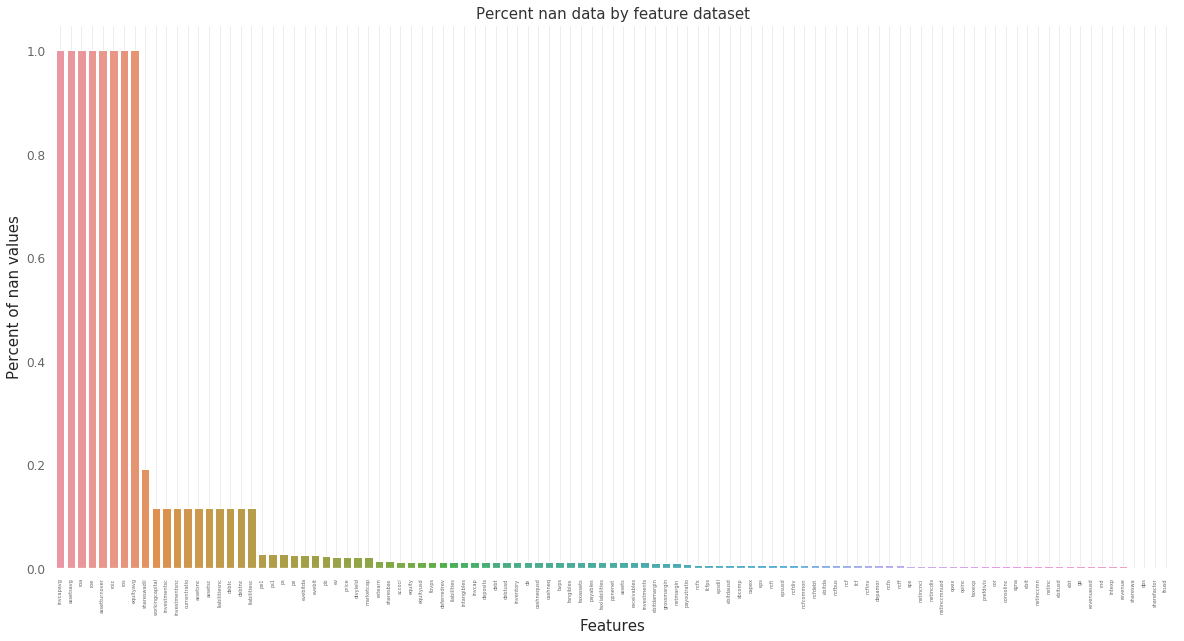

The percentage of dropped columns is 7%.
Dropped 8 columns out of 105


In [49]:
sf1 = utils_s.cleaning_dataframe(sf1,0.2)

In [50]:
sf1['roe'] = sf1['netinc'] / sf1['equity']
sf1['roa'] = sf1['netinc'] / sf1['assets']
sf1['fcf_yield'] = sf1['fcf'] / sf1['ev']

## 2 - 4 - Get two years data for DAILY

In [51]:
if load_data:
    quandl.export_table('SHARADAR/DAILY',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='daily.zip')

In [52]:


with zipfile.ZipFile('daily.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'DAILY':
        daily = pd.read_csv(item)
        daily['date'] = pd.to_datetime(daily['date'])
        daily = daily.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        daily.drop(['lastupdated'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


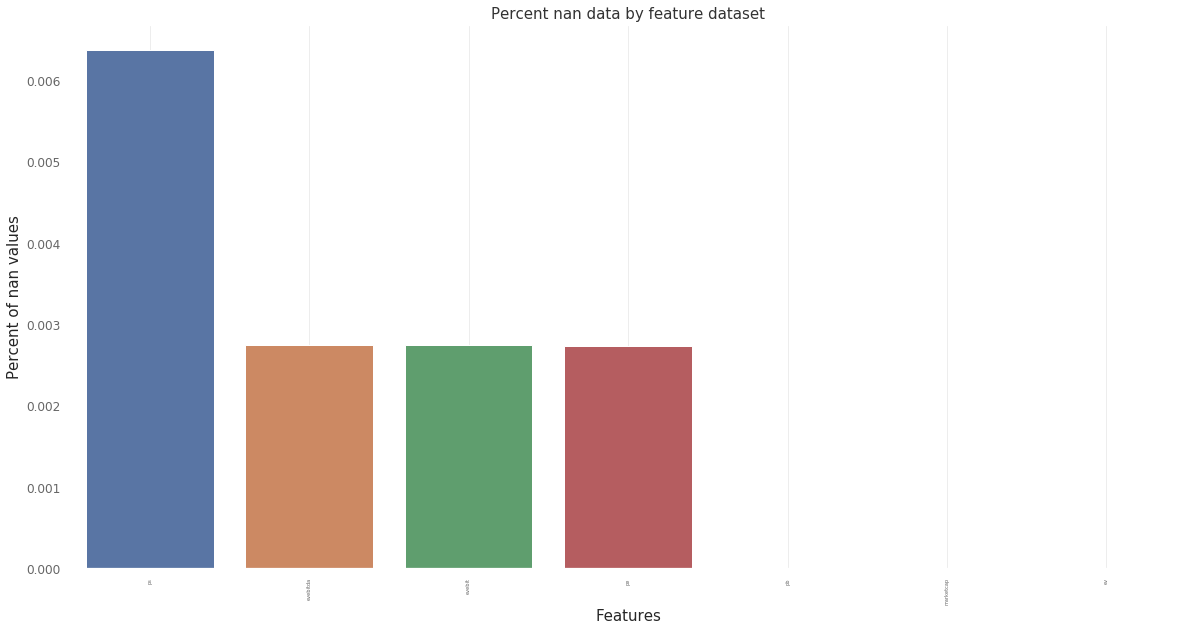

The percentage of dropped columns is 0%.
Dropped 0 columns out of 7


In [53]:
daily = utils_s.cleaning_dataframe(daily,0.2)

## 2 - 4 - Get two years data for SENTIMENT

In [54]:
if load_data:
    quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'
    quandl.export_table('IFT/NSA',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='sent.zip')

In [55]:
with zipfile.ZipFile('sent.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'IFT' and item.split('_')[1] == 'NSA':
        sent = pd.read_csv(item)
        sent['date'] = pd.to_datetime(sent['date'])
        sent = sent.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sent = sent[sent['exchange_cd']=='US']
        sent.drop(['name','exchange_cd'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


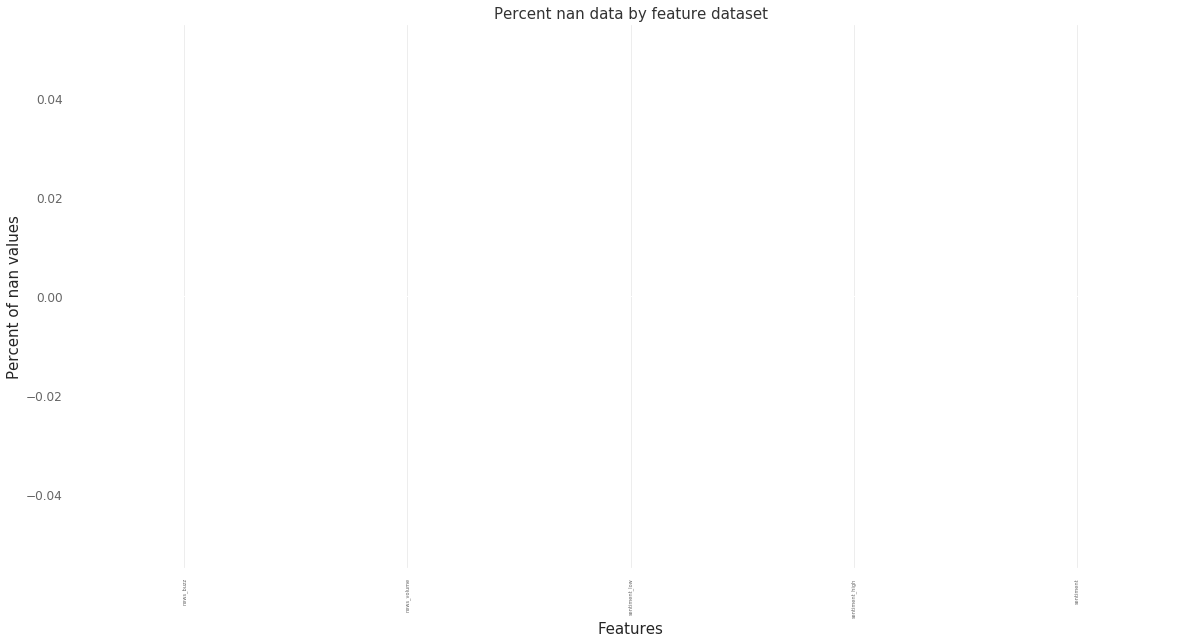

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [56]:
sent = utils_s.cleaning_dataframe(sent,0.2)

### Universe intersection

In [57]:
inter1 = set(sent['sentiment'].unstack('ticker').columns).intersection(set(sf1.index.levels[1]))
inter2 = inter1.intersection(set(daily.index.levels[1]))
new_universe = list(inter2)

In [58]:
len(new_universe)

174

# 3 - Sectors

In [59]:
meta_cleaned = meta_ex_sc_cu.loc[new_universe,:]

In [60]:
print ('Sectors in filtered data: \n')
sectors = {}
for i in set(meta_cleaned['sector']):
    print (' ',i)
    sectors[i] = list(meta_cleaned[meta_cleaned['sector'] == i].index)

Sectors in filtered data: 

  Financial Services
  Technology
  Industrials
  Consumer Cyclical
  Consumer Defensive
  Real Estate
  Utilities
  Healthcare


# 4 - Factorizing, Neutralizing and Resampling 

## 4 - 1 - Factorizing

In [61]:
close = ohlcv['close'].unstack('ticker')[new_universe]
openn = ohlcv['open'].unstack('ticker')[new_universe]
high = ohlcv['high'].unstack('ticker')[new_universe]
low = ohlcv['low'].unstack('ticker')[new_universe]

In [62]:
#close.to_csv('close.csv')

In [63]:
pricing = openn.loc[slice(start,end),:].tz_localize('UTC')[new_universe]

In [64]:
# daily

daily_data = {}

for i in daily_in.keys():
    
    df_daily = daily[i].unstack('ticker')
    reversion = factorize.Momentum(df_daily,daily_in[i])*-1
    smoothed_reversion = factorize.Smooth(reversion,smoothed_value)
    smoothed_reversion.index = pd.to_datetime(smoothed_reversion.index)
    smoothed_reversion = smoothed_reversion.loc[slice(start,end),:]

    result = []
    for sec in sectors.keys():
        result.append(smoothed_reversion[sectors[sec]].sub(smoothed_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_reversion_neutralized = pd.concat(result,axis=1)
    smoothed_reversion_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_reversion_neutralized),
                                                         index = smoothed_reversion_neutralized.index,
                                                         columns = smoothed_reversion_neutralized.columns)
    
    daily_data[i] = smoothed_reversion_neutralized_scaled


In [65]:
# SMA
sma_data = {}

for name,period in sma_in.items():

    df= pd.DataFrame(index = close.index)

    try:
        for tick in close.columns:
            df[tick] = talib.SMA(close[tick].values, timeperiod=period)
    except:
        pass

    sma_min = (close - df)*-1
    smoothed_sma_min = factorize.Smooth(sma_min,smoothed_value)
    smoothed_sma_min.index = pd.to_datetime(smoothed_sma_min.index)
    smoothed_sma_min = smoothed_sma_min.loc[slice(start,end),:]
    
    # Neutralizing by sector
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sma_min[sectors[sec]].sub(smoothed_sma_min[sectors[sec]].mean(axis=1),axis=0))

    smoothed_sma_min_neutralized = pd.concat(result,axis=1)    
    
    smoothed_sma_min_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_sma_min_neutralized),
                                                              index = smoothed_sma_min_neutralized.index,
                                                              columns = smoothed_sma_min_neutralized.columns)
    
    sma_data[name] = smoothed_sma_min_neutralized_scaled
    

In [66]:
over_data = {}

for name,period in over_in.items():
    overnight_sentiment = factorize.overnight_sentiment(close, openn, window_length=1, trailing_window=period)*-1
    smoothed_overnight_sentiment = factorize.Smooth(overnight_sentiment,smoothed_value)
    
    smoothed_overnight_sentiment.index = pd.to_datetime(smoothed_overnight_sentiment.index)
    
    smoothed_overnight_sentiment = smoothed_overnight_sentiment.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_overnight_sentiment[sectors[sec]].sub(smoothed_overnight_sentiment[sectors[sec]].mean(axis=1),axis=0))

    smoothed_overnight_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    over_data[name] = smoothed_overnight_sentiment_neutralized_scaled
    

In [67]:
# mean reversion
momentum_data = {}

for name,period in momentum_in.items():
    
    mean_reversion = factorize.Momentum(close,period)*-1
    smoothed_mean_reversion = factorize.Smooth(mean_reversion,smoothed_value)
    
    smoothed_mean_reversion.index = pd.to_datetime(smoothed_mean_reversion.index)
    smoothed_mean_reversion = smoothed_mean_reversion.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_mean_reversion[sectors[sec]].sub(smoothed_mean_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_mean_reversion_neutralized_scaled = pd.concat(result,axis=1)
  
    momentum_data[name] = smoothed_mean_reversion_neutralized_scaled


In [68]:
# direction
direction_data = {}

for name,period in direction_in.items():
    
    direct = factorize.direction(close, openn, 1, period)
    smoothed_direct = factorize.Smooth(direct,smoothed_value)

    smoothed_direct.index = pd.to_datetime(smoothed_direct.index)
    smoothed_direct = smoothed_direct.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_direct[sectors[sec]].sub(smoothed_direct[sectors[sec]].mean(axis=1),axis=0))

    smoothed_direct_neutralized_scaled = pd.concat(result,axis=1)
    
    direction_data[name] = smoothed_direct_neutralized_scaled

In [69]:
# sentiment
sent_data = {}

for name,period in sent_in.items():
    
    sentiment = factorize.sentiment(close, high, low, sent, period, new_universe)
    smoothed_sentiment= factorize.Smooth(sentiment,smoothed_value)
    smoothed_sentiment.index = pd.to_datetime(smoothed_sentiment.index)
    smoothed_sentiment = smoothed_sentiment.loc[slice(start,end),:]
    
    to_drop = smoothed_sentiment.columns ^ close.columns

    for i in to_drop:
        sectors[meta_cleaned.loc[i]['sector']].remove(i)
        
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sentiment[sectors[sec]].sub(smoothed_sentiment[sectors[sec]].mean(axis=1),axis=0))
    
    smoothed_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    sent_data[name] = smoothed_sentiment_neutralized_scaled

## 4 - 2 - Fundamentals 

### 4 - 2 - 1 - Indicators

In [70]:
#indicator=ind
indicators_desc = quandl.get_table('SHARADAR/INDICATORS')
sf1_ind = indicators_desc[indicators_desc['table']=='SF1']

In [71]:
# Columns description of cleaned SF1
for i in sf1.columns:
    try:
        print (i,':',sf1_ind[sf1_ind['indicator']==i]['title'].values[0],':',sf1_ind[sf1_ind['indicator']==i]['description'].values[0],'\n')
    except:
        pass

accoci : Accumulated Other Comprehensive Income : [Balance Sheet] A component of [Equity] representing the accumulated change in equity from transactions and other events and circumstances from non-owner sources; net of tax effect; at period end. Includes foreign currency translation items; certain pension adjustments; unrealized gains and losses on certain investments in debt and equity securities. 

assets : Total Assets : [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables]. 

assetsc : Current Assets : [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets. 

assetsnc : Assets Non-Current : [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total As

pb : Price to Book Value : [Metrics] Measures the ratio between [MarketCap] and [EquityUSD]. 

pe : Price Earnings (Damodaran Method) : [Metrics] Measures the ratio between [MarketCap] and [NetIncCmnUSD] 

pe1 : Price to Earnings Ratio : [Metrics] An alternative to [PE] representing the ratio between [Price] and [EPSUSD]. 

ppnenet : Property Plant & Equipment Net : [Balance Sheet] A component of [Assets] representing the amount after accumulated depreciation; depletion and amortization of physical assets used in the normal conduct of business to produce goods and services and not intended for resale. Includes Operating Right of Use Assets. 

prefdivis : Preferred Dividends Income Statement Impact : [Income Statement] Income statement item reflecting dividend payments to preferred stockholders. Subtracted from Net Income to Parent [NetInc] to obtain Net Income to Common Stockholders [NetIncCmn]. 

price : Share Price (Adjusted Close) : [Entity] The price per common share adjusted for s

### 4 - 2 - 2 - Factorizing, Neutralizing and Resampling

In [72]:
data = {}
for i in selected_indicators:
    
    df = sf1[i].unstack('ticker')[new_universe]
    df.fillna(df.mean(axis=0),inplace=True)
    
    # Calculating Return
    returns = factorize.Returns(df,window_length=1)
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)    
    
    returns_drz = pd.DataFrame(data = preprocessing.scale(returns),
                               index = returns.index,
                               columns = returns.columns) 

    result = []
    for sec in sectors.keys():
        result.append(returns_drz[sectors[sec]].sub(returns[sectors[sec]].mean(axis=1),axis=0))
    
    returns_neutralize = pd.concat(result,axis=1)

    # Resampling
    chunk = (ohlcv.index.levels[0][-1]+datetime.timedelta(days=1)).date()
    chunk_minus = ohlcv.index.levels[0][-1].date()
    returns_neutralize.loc[chunk,:] = np.nan
    returns_neutralize.index = pd.to_datetime(returns_neutralize.index)
    returns_neutralize_resampled = returns_neutralize.resample('D').pad()
    returns_neutralize_resampled = returns_neutralize_resampled.loc[start_sep:chunk_minus,:]
    
    # Drop holidays
    holidays = returns_neutralize_resampled.index ^ ohlcv.index.levels[0]
    returns_neutralize_resampled.drop(list(holidays),axis=0,inplace = True)
    returns_neutralize_resampled.index.name = ohlcv.index.levels[0].name
    
    # Slicing 1 year
    returns_neutralize_resampled_1y = returns_neutralize_resampled.loc[slice(start,end),:]

    data[i] = returns_neutralize_resampled_1y

## 4 - 4 - Multiindex factors

In [73]:
result = []

for ind in selected_indicators:
    
    fund_return_neutralized_stacked = data[ind].stack().to_frame(ind)
    result.append(fund_return_neutralized_stacked)

for i in daily_in.keys():

    daily_stacked = daily_data[i].stack().to_frame('daily_{}{}days'.format(i,daily_in[i]))
    result.append(daily_stacked)

for i in sma_data.keys():

    sma_stacked = sma_data[i].stack().to_frame('sma{}'.format(sma_in[i]))
    result.append(sma_stacked)

for i in momentum_data.keys():
    
    momentum_stacked = momentum_data[i].stack().to_frame('momentum{}days'.format(momentum_in[i]))
    result.append(momentum_stacked)
    
for i in over_data.keys():
    
    over_stacked = over_data[i].stack().to_frame('overnight_sent{}days'.format(over_in[i]))
    result.append(over_stacked)    

for i in direction_data.keys():
    
    direct_stacked = direction_data[i].stack().to_frame('direction{}days'.format(direction_in[i]))
    result.append(direct_stacked)

for i in sent_data.keys():
    
    sent_stacked = sent_data[i].stack().to_frame('sentiment{}days'.format(sent_in[i]))
    result.append(sent_stacked)    
    
all_factors = pd.concat(result,axis=1)

all_factors.index = all_factors.index\
                               .set_levels([all_factors.index.levels[0].tz_localize('UTC'), all_factors.index.levels[1]])
#all_factors.dropna(axis=0, inplace = True)
all_factors

cashneq  daily_marketcap100days  \
date                      ticker                                     
2019-07-08 00:00:00+00:00 SPGI    1.196286                0.732802   
                          SCHW   -0.337560                1.561971   
                          COF    -0.398413               -0.286383   
                          CB      0.019508               -0.650451   
                          ICE     0.584205               -0.369547   
                          GS      0.392904                1.256241   
                          PYPL    0.230411               -0.187034   
                          PNC     0.996316               -0.262433   
                          AON    -0.163251               -0.905933   
                          V       0.170008               -1.812578   
                          BAC    -0.393373                1.000260   
                          MA     -0.067473               -1.073794   
                          BLK     0.035383                0.582612   
                          CME     0.048486               -0.471801   
                          JPM    -0.692915                0.310990   
                          USB    -0.001163                0.182173   
                          WFC     0.887857                0.427418   
                          MS     -0.049437                0.644085   
                          C      -0.091639               -0.069599   
                          AXP    -1.459105               -1.443756   
                          ENPH    0.656008               -0.393977   
                          FB      0.542831               -0.734567   
                          IBM     0.773032               -0.300566   
                          ORCL    0.976684               -1.783656   
                          ADBE    0.382068               -0.089591   
                          INTC   -0.055549                1.001922   
                          EA     -1.655663                0.852816   
                          SHOP    0.702661               -0.685678   
                          TWTR   -0.170850               -0.593272   
                          NVDA    0.616822                1.583486   
...                                    ...                     ...   
2020-07-02 00:00:00+00:00 TMO    -1.266014               -0.548335   
                          BIIB    0.174930                1.653293   
                          ILMN   -1.591828               -2.461863   
                          ISRG   -0.974807               -0.357435   
                          UNH    -1.237194               -0.211973   
                          HUM     0.502391               -0.613035   
                          ANTM   -0.330343               -0.284207   
                          SYK    -0.660131                1.008892   
                          LLY     1.269714               -0.743796   
                          VRTX   -2.929511               -0.860141   
                          DXCM   -0.241688               -1.340679   
                          CVS     0.590752                0.657687   
                          CNC    -1.993006               -1.002142   
                          REGN   -2.107283               -1.399085   
                          HCA     0.611589                2.198144   
                          ZTS    -1.412347                0.948455   
                          JNJ     0.728059                1.172490   
                          BMY    -1.082358               -0.621305   
                          ABT     1.316462               -0.097715   
                          ABBV   -2.756740               -1.182142   
                          BSX    -1.941624                1.052262   
                          MDT     0.456944                1.944013   
                          DHR     0.267760               -0.240024   
                          MRNA    0.278833               -1.401665   
                          CI      0.609776   

In [74]:
all_factors.isna().sum()

cashneq                   0
daily_marketcap100days    0
daily_evebitda100days     0
sma200                    0
momentum252days           0
overnight_sent5days       0
direction100days          0
sentiment100days          0
dtype: int64

# 5 - All factors analysis

In [75]:
print ('Rebalance period set to {} days for factor analysis'.format(rebalance_period))

Rebalance period set to 5 days for factor analysis


In [76]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                          prices=pricing, 
                                                          periods=[rebalance_period], 
                                                          quantiles=5,
                                                          filter_zscore=20,
                                                          max_loss=0.35)
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% en

### 5 - 1 - Cumulated factor return

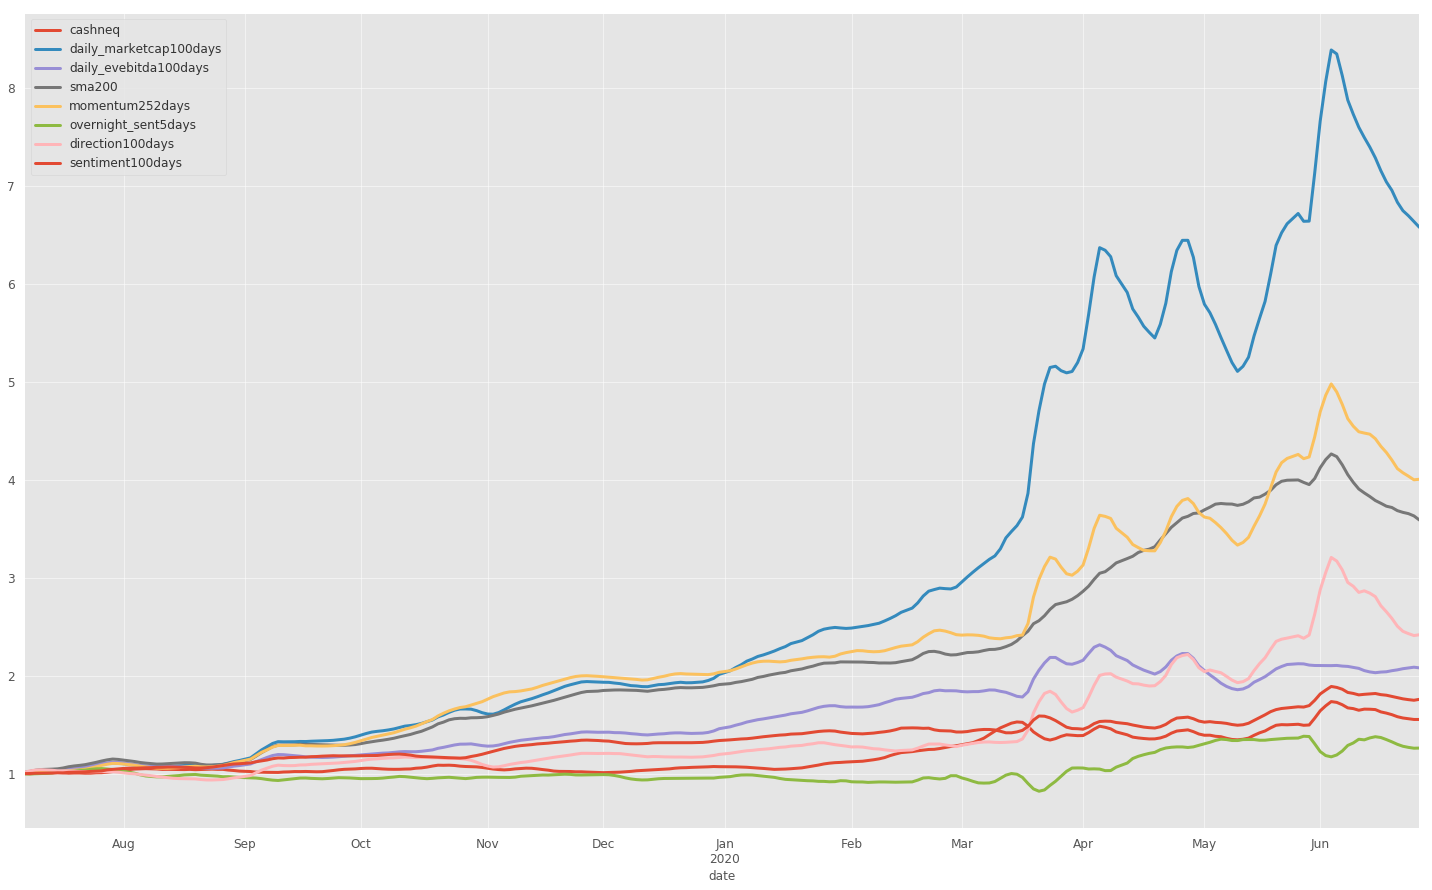

In [77]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 15)

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot(lw=3);

### 5 - 2 - Quantile analysis

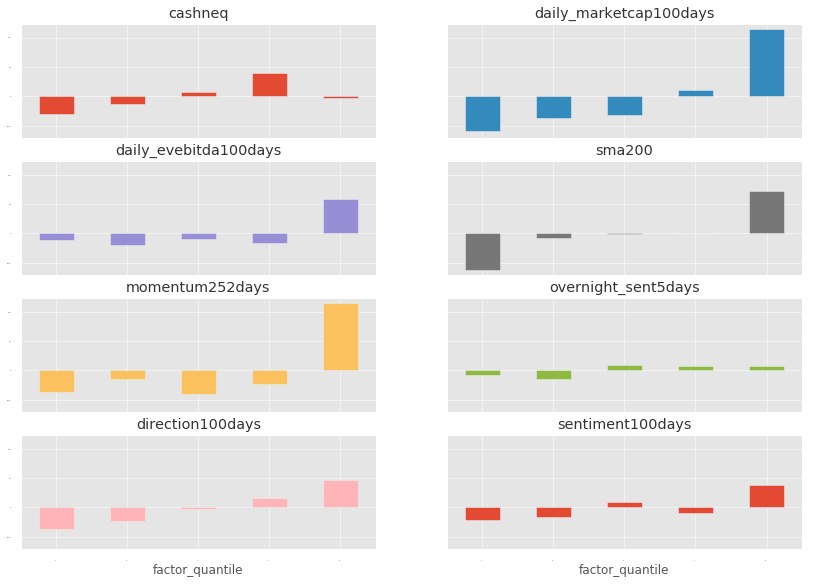

In [78]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(20,2),
    figsize=(14, 50),
    legend=False, fontsize=2);

### 5 - 3 - Factor Rank Autocorrelation

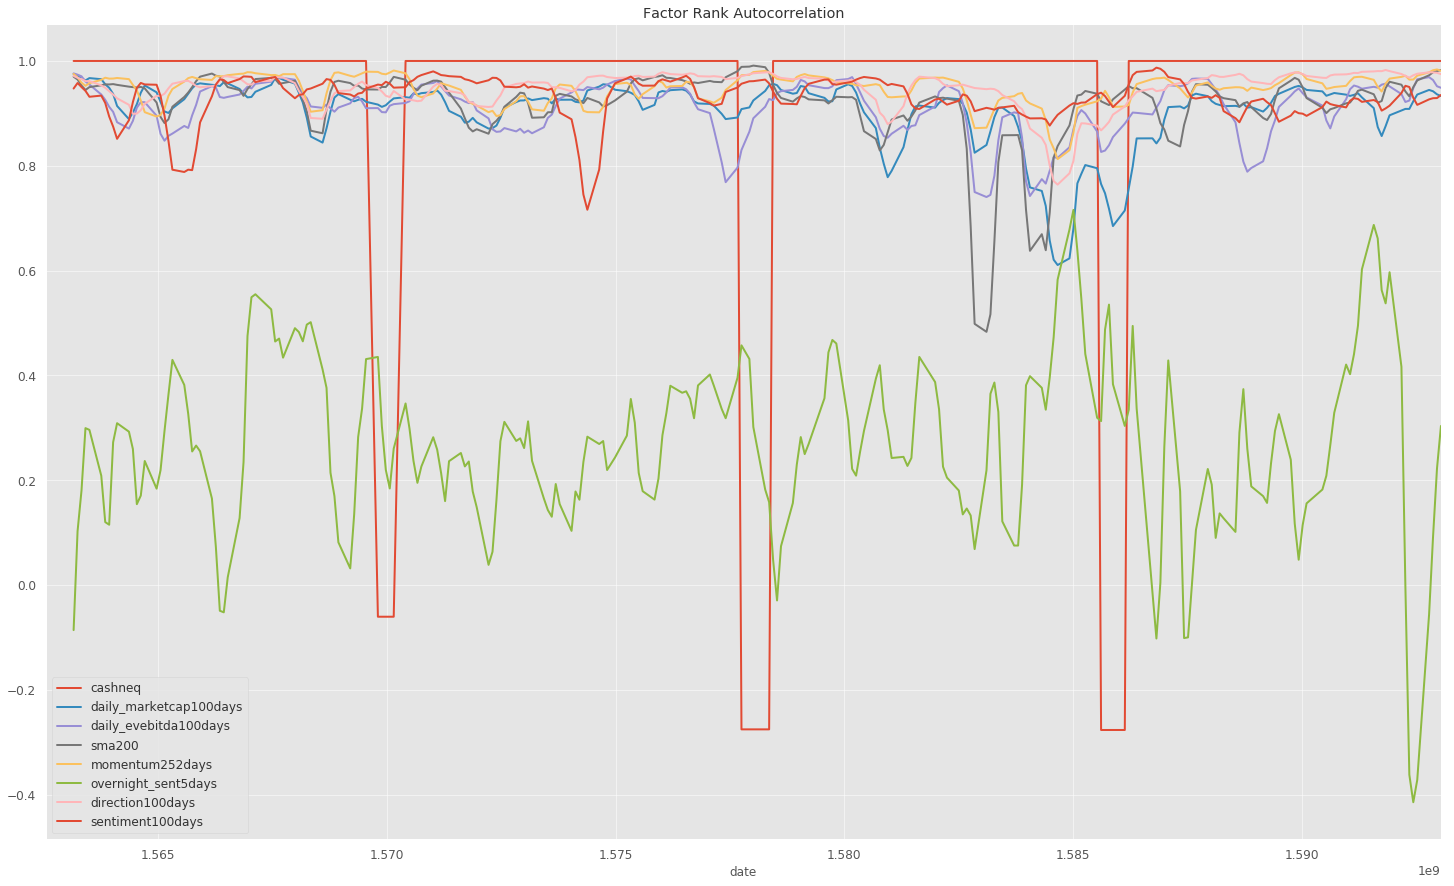

In [79]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data,period=rebalance_period)

ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

### 5 - 4 - Sharpe ratio

In [80]:
def sharpe_ratio(factor_returns, annualization_factor):

    df_sharpe = pd.Series(annualization_factor*factor_returns.mean()/factor_returns.std())
    
    return df_sharpe

In [81]:
daily_annualization_factor = np.sqrt(252)
df_sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [82]:
df_sharpe.sort_values(ascending=False)

sma200                    9.86
daily_marketcap100days    6.28
momentum252days           5.67
sentiment100days          4.44
daily_evebitda100days     4.38
direction100days          3.02
cashneq                   2.91
overnight_sent5days       1.12
dtype: float64

# 6 - Combined Alpha Factors

## 6 - 1 - Combining selceted factors

In [83]:

selected_factors = [
                         'sma200',
                         'daily_marketcap100days',
                         'direction100days',
                         'momentum252days',
                         'sentiment100days',
                         'cashneq'
                   ]

print('Selected Factors:\n{} '.format(',\n'.join(selected_factors)))

all_factors = all_factors[selected_factors]

Selected Factors:
sma200,
daily_marketcap100days,
direction100days,
momentum252days,
sentiment100days,
cashneq 


Time to train full ML pipline: 1.0161333084106445 secs
Accuracy on train set = 51.03%
Predictions: [-1. -1. -1. ... -1. -1. -1.]
Probabilities of class == 1: [49.9999886 49.9999886 49.9999886 ... 49.9999886 49.9999886 49.9999886]
Accuracy on test set = 50.00%
Log-loss = 0.69315


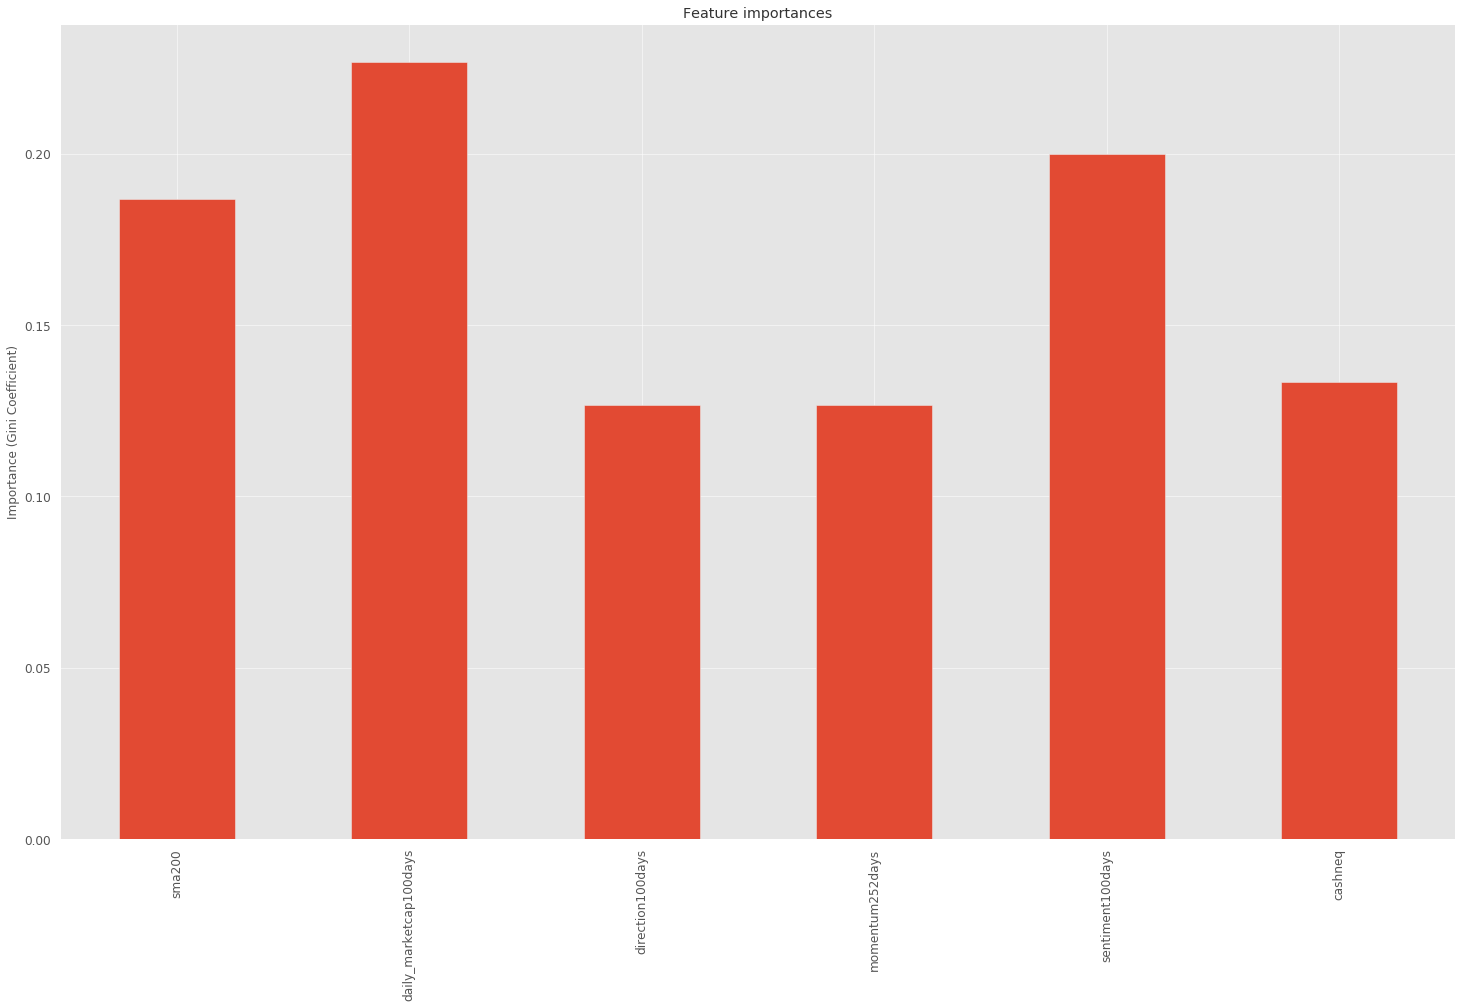

In [84]:
feature_importances = feature_weights.feature_importance(n_fwd_days = rebalance_period, 
                                                         close = close, 
                                                         all_factors = all_factors)

In [85]:
feature_importances

weights
factors                         
sma200                  0.186667
daily_marketcap100days  0.226667
direction100days        0.126667
momentum252days         0.126667
sentiment100days        0.200000
cashneq                 0.133333

In [86]:
all_factors_copy = all_factors.copy() 

In [87]:
for factor in selected_factors:
    all_factors_copy.loc[:,factor] = feature_importances.loc[factor][0] * all_factors.loc[:,factor]
all_factors_copy.loc[:,'alpha_vector'] = all_factors.sum(axis=1)
all_factors = all_factors_copy  

In [88]:
vec = pd.DataFrame(data=all_factors['alpha_vector'],columns = ['alpha_vector','sector'])
for date in vec.index.levels[0]:
    vec.loc[date,['sector']] = meta_ex_sc_cu.loc[vec.index.levels[1]]['sector'].values
sectors = vec['sector']

In [89]:
vec.shape

(43674, 2)


## 6 - 2 - Creating clean factor data

In [90]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = all_factors['alpha_vector'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = len(qunatile_portions)-1,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 6 - 3 - Creating tear sheets 

In [91]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period='{}D'.format(rebalance_period),
                                       capital=10000,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       #quantiles=[1,2,4,5],
                                       groups=sectors,
                                       benchmark_period='{}D'.format(rebalance_period))

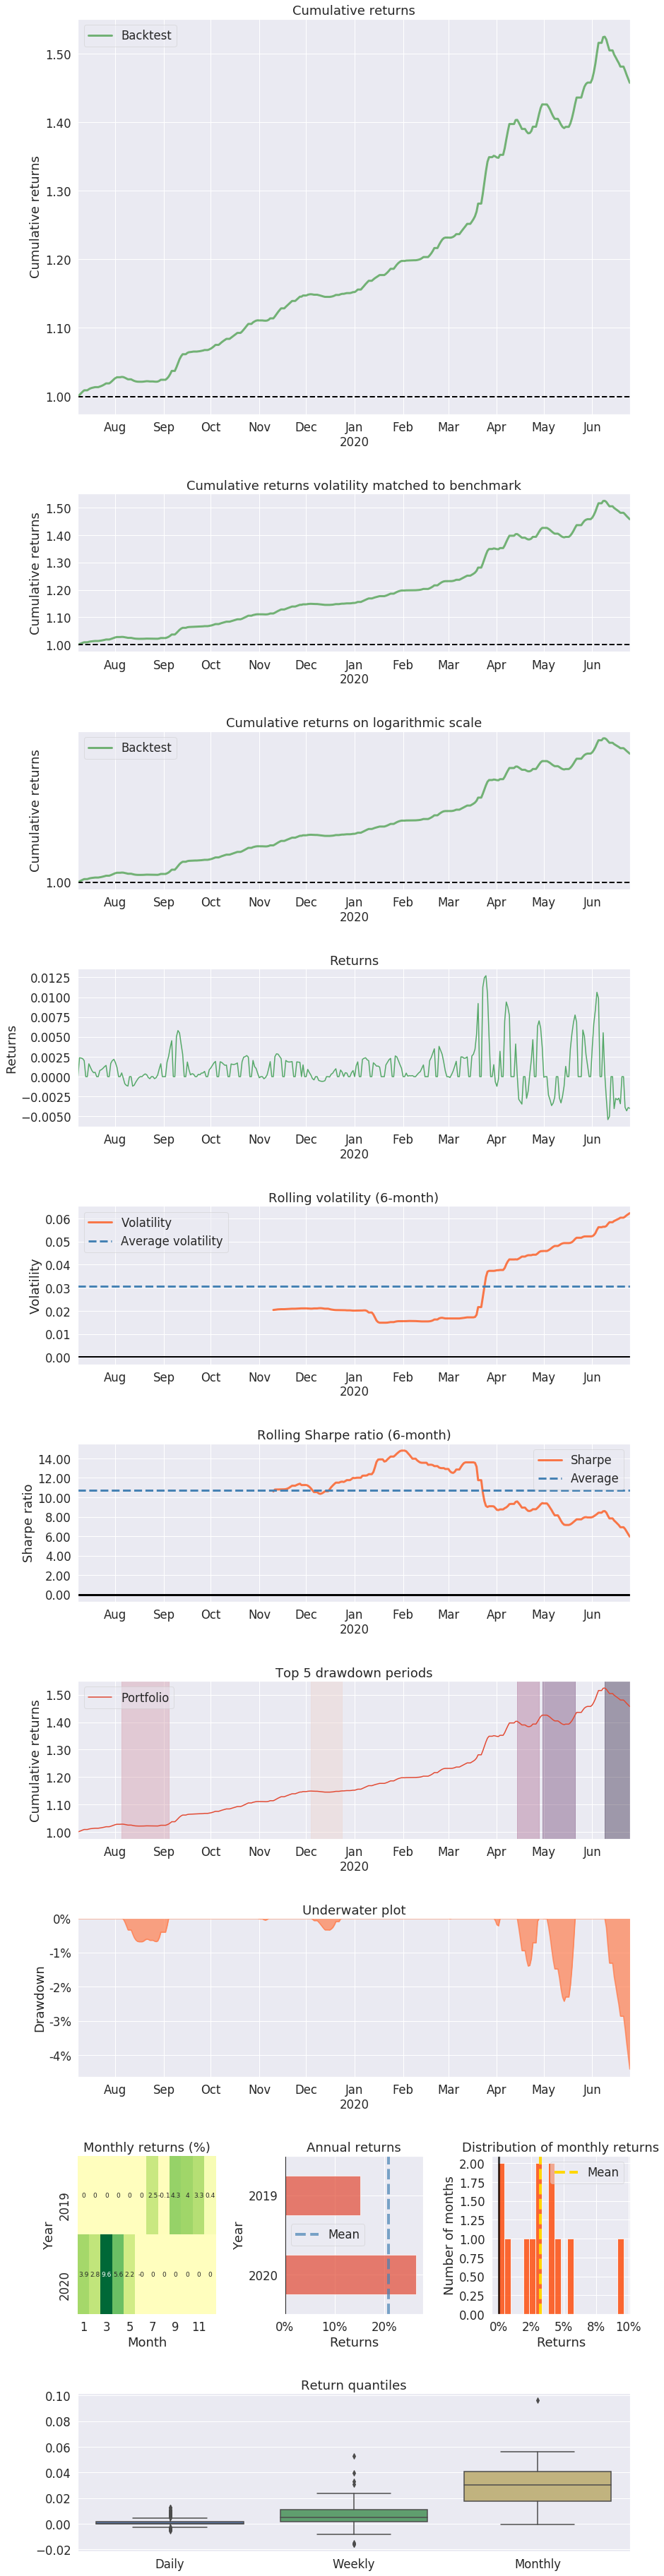

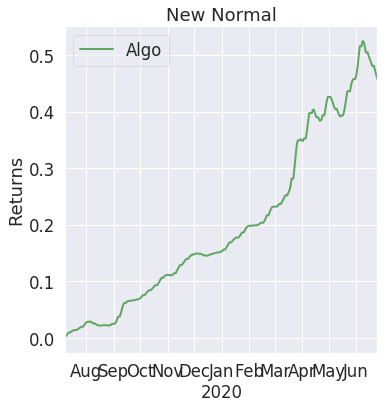

In [92]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min        max      mean       std  count   count %
factor_quantile                                                           
1               -11.372189  -3.411433 -5.976809  1.229003   2169  5.172414
2                -7.477918  -2.400077 -4.362094  0.812652   2169  5.172414
3                -6.194766  -2.113577 -3.562332  0.753513   1928  4.597701
4                -5.692486  -1.503228 -2.926400  0.683898   2169  5.172414
5                -4.789535  -1.188801 -2.384975  0.593688   2169  5.172414
6                -3.813085  -0.805711 -1.926631  0.507897   1928  4.597701
7                -3.086169  -0.403743 -1.495210  0.446382   2169  5.172414
8                -2.279645  -0.015217 -1.038727  0.381047   2169  5.172414
9                -1.909252   0.453428 -0.580227  0.340117   1928  4.597701
10               -1.225979   1.002576 -0.141523  0.322513   2169  5.172414
11               -0.766954   1.949723  0.299733  0.378368   2169  5.172414
12               -0.172405   2.345613  0.745736  0.443335   1928  4.597701
13                0.182916   2.923696  1.179954  0.510058   2169  5.172414
14                0.444744   3.643311  1.656687  0.585389   2169  5.172414
15                0.986615   4.559462  2.166614  0.703772   1928  4.597701
16                1.522895   5.663490  2.729165  0.817296   2169  5.172414
17                2.211783   6.676162  3.383605  0.909233   2169  5.172414
18                2.835625   7.244160  4.053865  0.987166   1928  4.597701
19                3.268921   8.759978  4.923343  1.114023   2169  5.172414
20                4.039688  14.238218  6.541661  1.787150   2169  5.172414

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.445    0.441    0.395
beta                                             0.217    0.184    0.071
Mean Period Wise Return Top Quantile (bps)     106.362  105.716   92.092
Mean Period Wise Return Bottom Quantile (bps)  -64.230  -63.858  -54.714
Mean Period Wise Spread (bps)                  170.592  167.549  144.379

<Figure size 1800x1080 with 0 Axes>

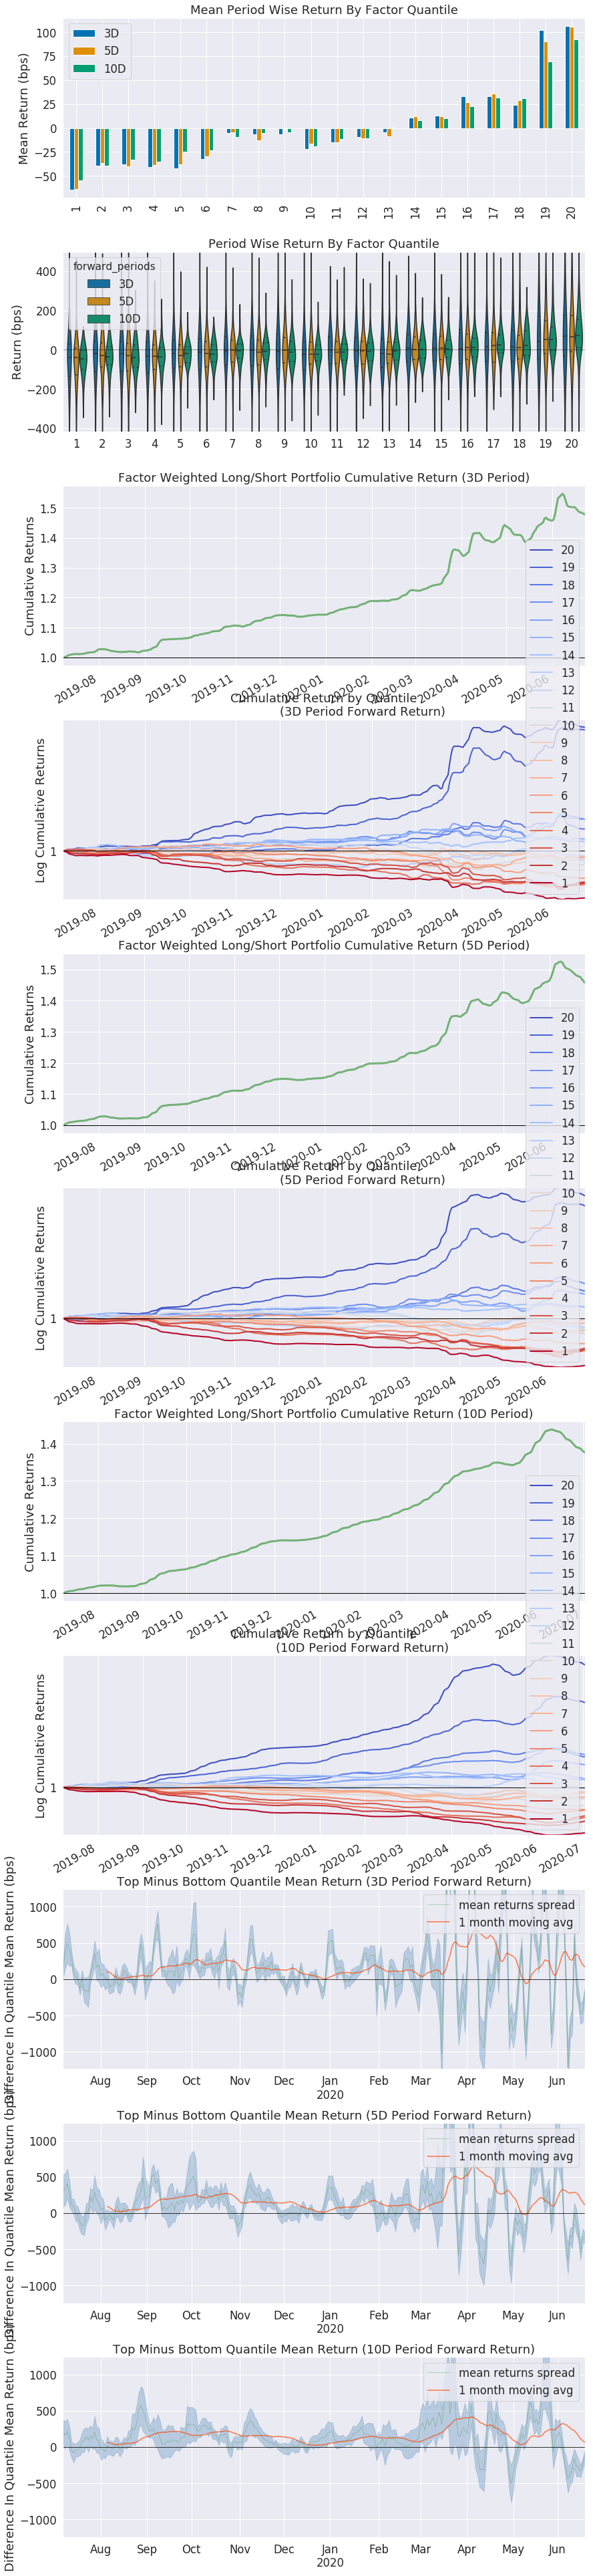

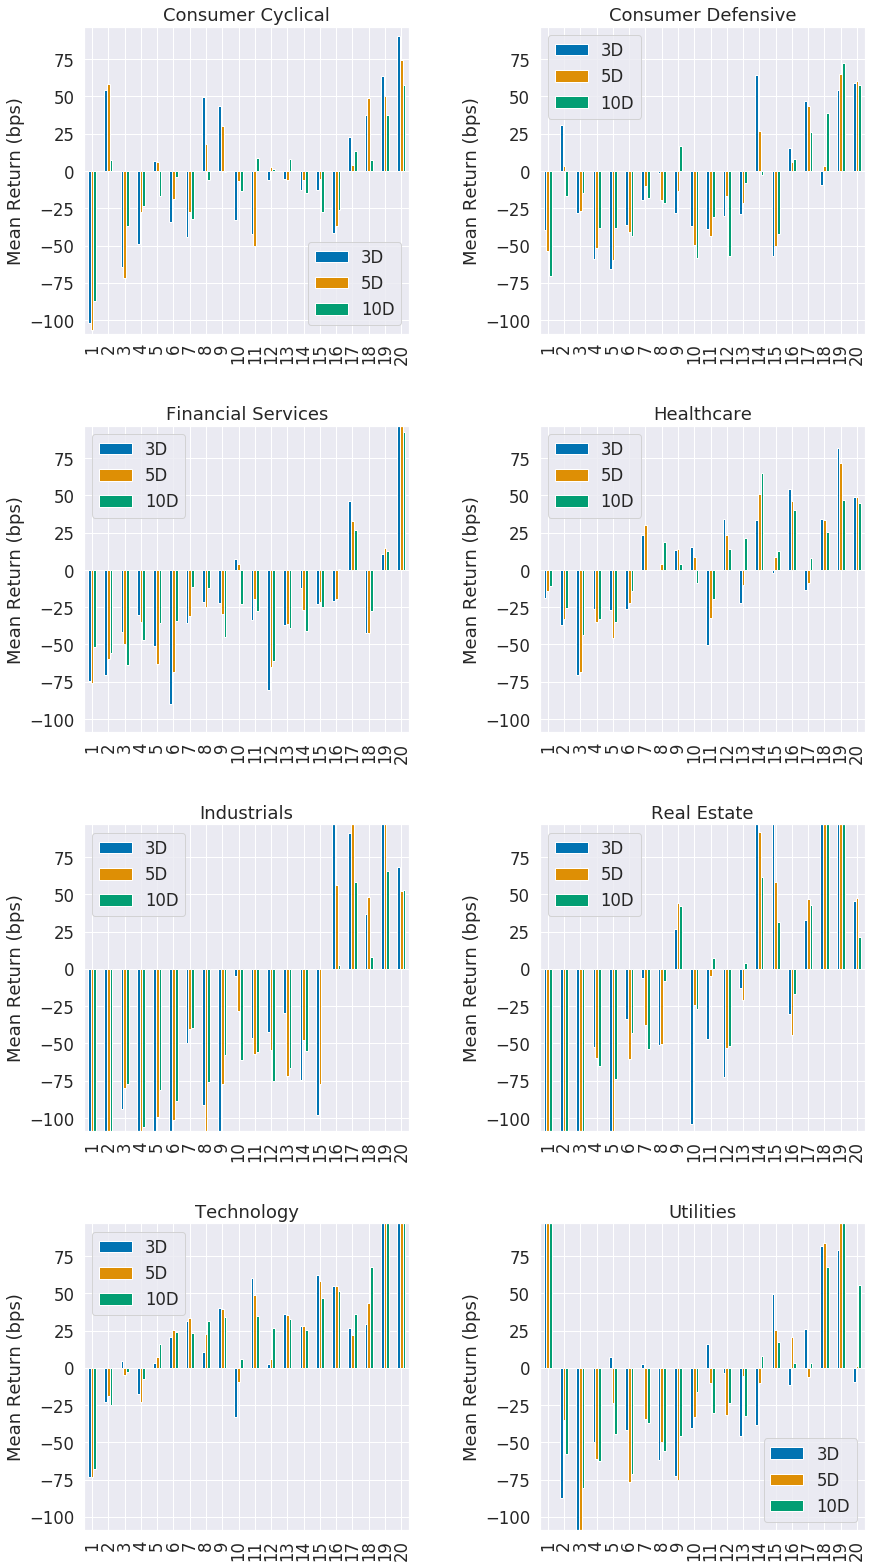

Information Analysis


3D     5D     10D
IC Mean           0.073  0.097   0.144
IC Std.           0.206  0.211   0.202
Risk-Adjusted IC  0.356  0.459   0.712
t-stat(IC)        5.527  7.123  11.046
p-value(IC)       0.000  0.000   0.000
IC Skew          -0.125 -0.208  -0.879
IC Kurtosis       0.033 -0.160   0.665

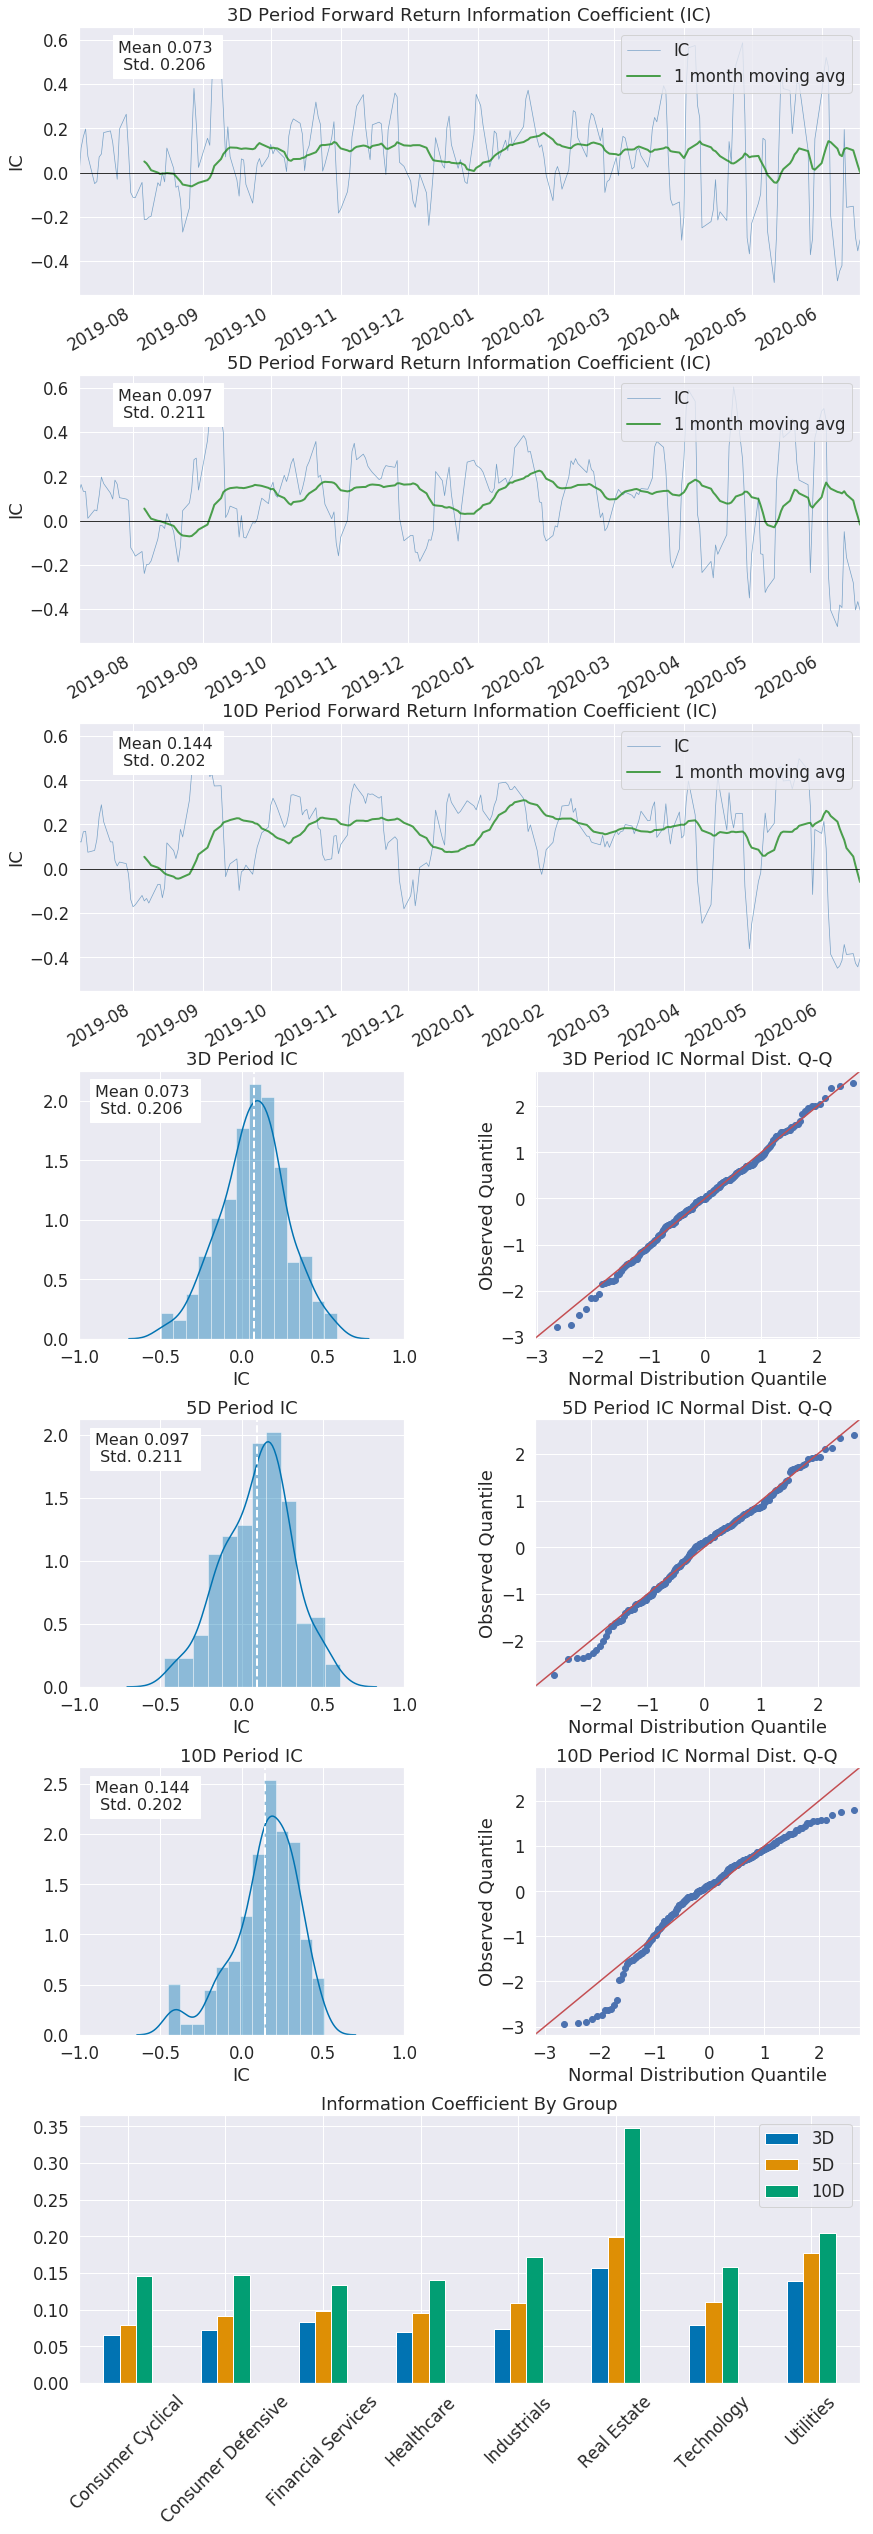

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover    0.449  0.208  0.310
Quantile 2 Mean Turnover    0.736  0.469  0.605
Quantile 3 Mean Turnover    0.841  0.608  0.726
Quantile 4 Mean Turnover    0.839  0.632  0.740
Quantile 5 Mean Turnover    0.842  0.673  0.768
Quantile 6 Mean Turnover    0.905  0.753  0.845
Quantile 7 Mean Turnover    0.868  0.717  0.792
Quantile 8 Mean Turnover    0.878  0.724  0.805
Quantile 9 Mean Turnover    0.906  0.741  0.833
Quantile 10 Mean Turnover   0.878  0.715  0.806
Quantile 11 Mean Turnover   0.884  0.735  0.815
Quantile 12 Mean Turnover   0.889  0.741  0.828
Quantile 13 Mean Turnover   0.882  0.723  0.823
Quantile 14 Mean Turnover   0.873  0.706  0.796
Quantile 15 Mean Turnover   0.877  0.722  0.822
Quantile 16 Mean Turnover   0.842  0.657  0.756
Quantile 17 Mean Turnover   0.827  0.640  0.739
Quantile 18 Mean Turnover   0.825  0.636  0.739
Quantile 19 Mean Turnover   0.757  0.502  0.621
Quantile 20 Mean Turnover   0.477  0.216  0.310

3D     5D    10D
Mean Factor Rank Autocorrelation  0.964  0.925  0.831

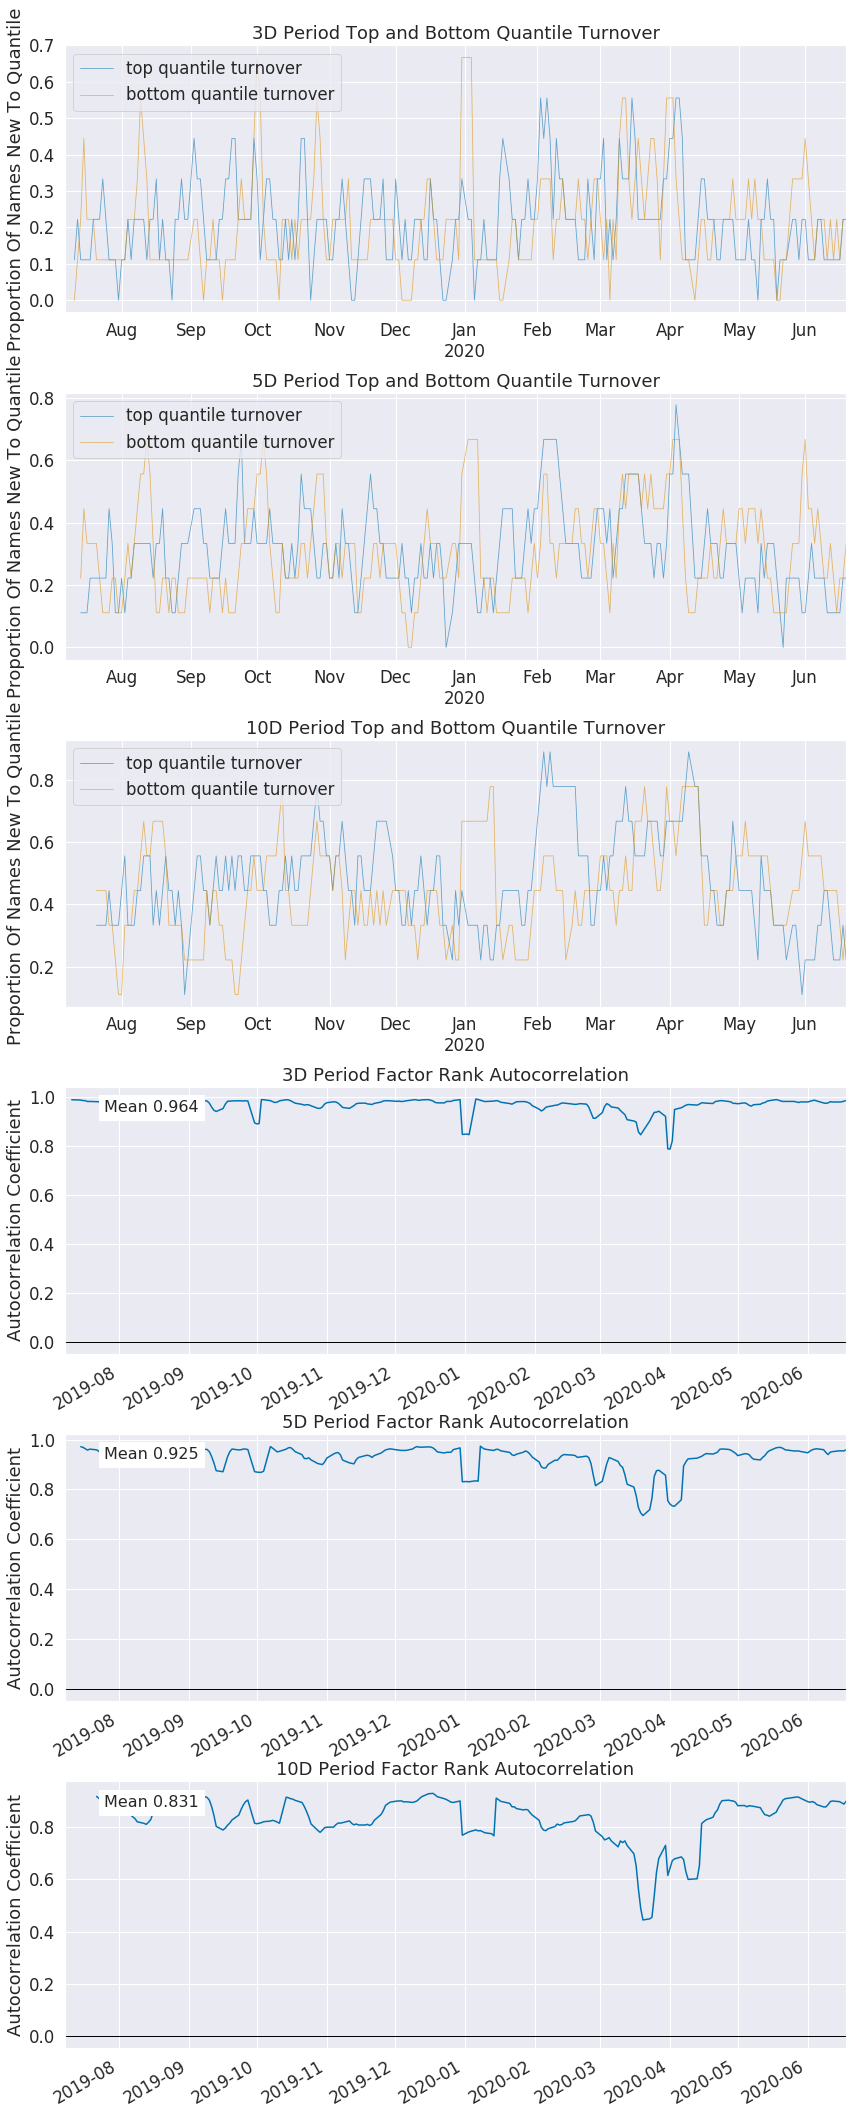

In [93]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

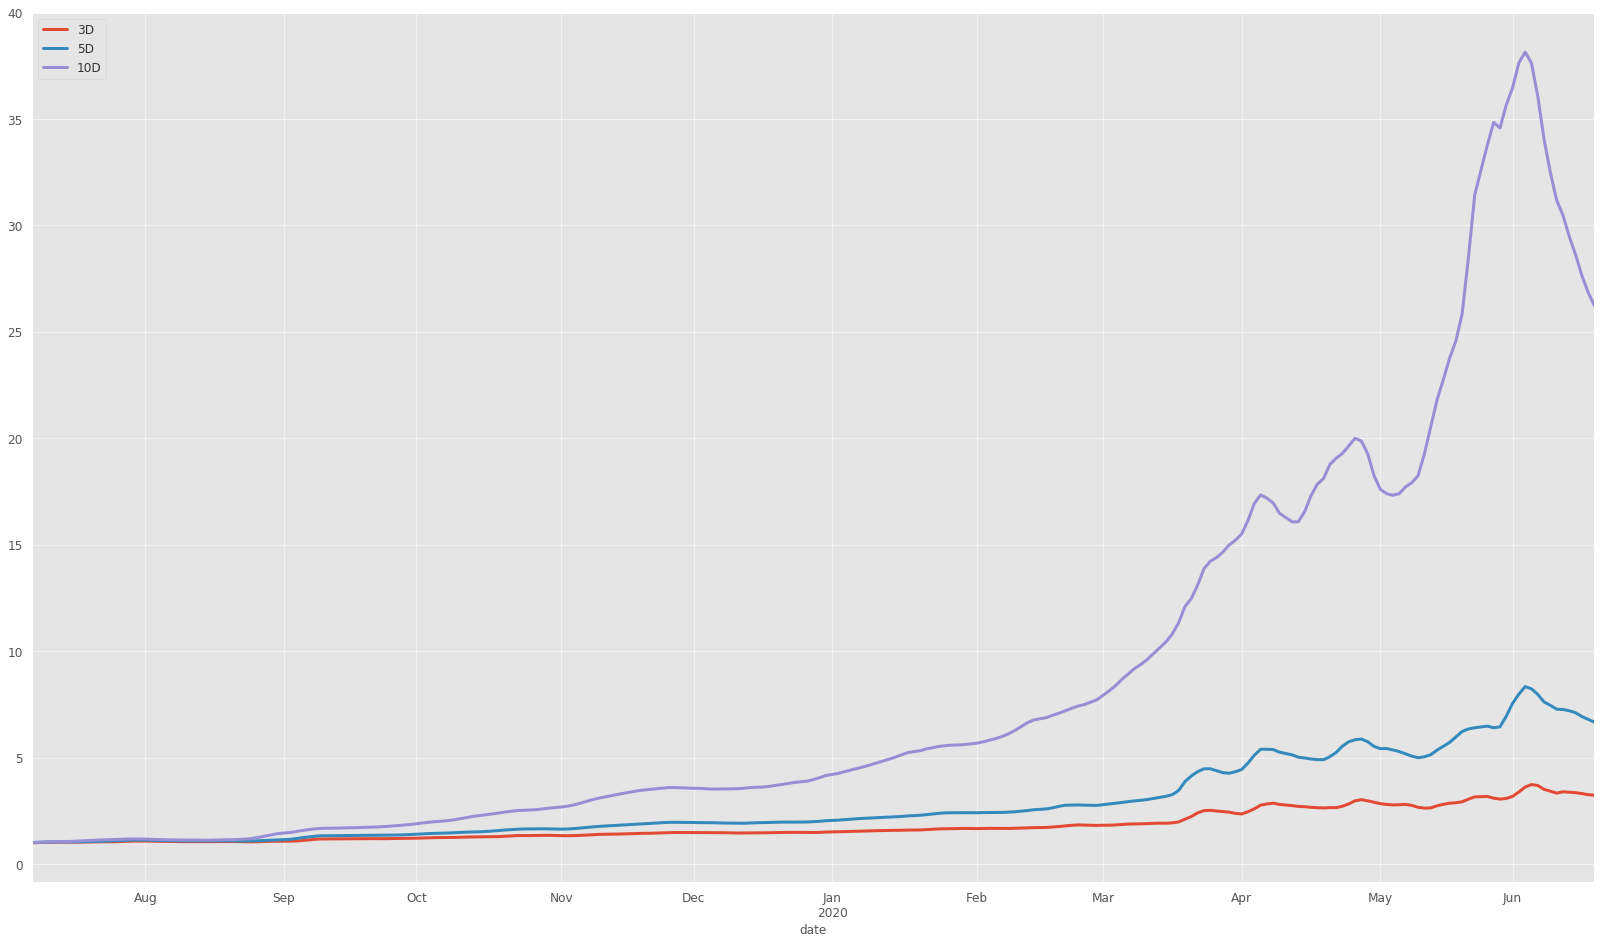

In [94]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data)

(1+ls_factor_returns).cumprod().plot(lw=3);

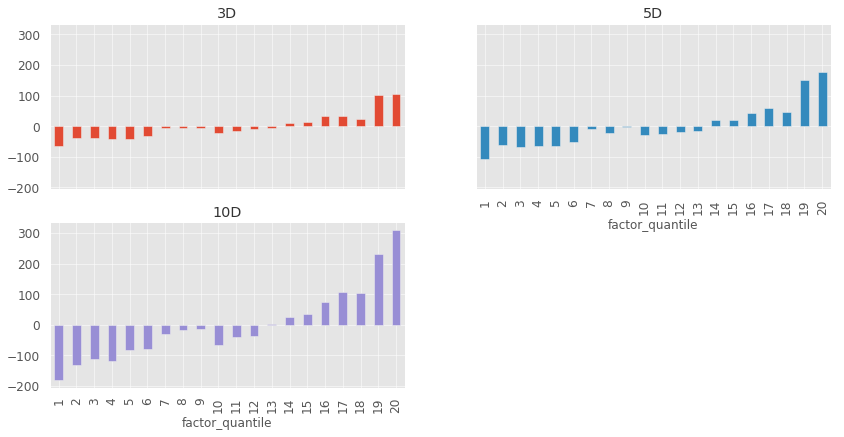

In [95]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

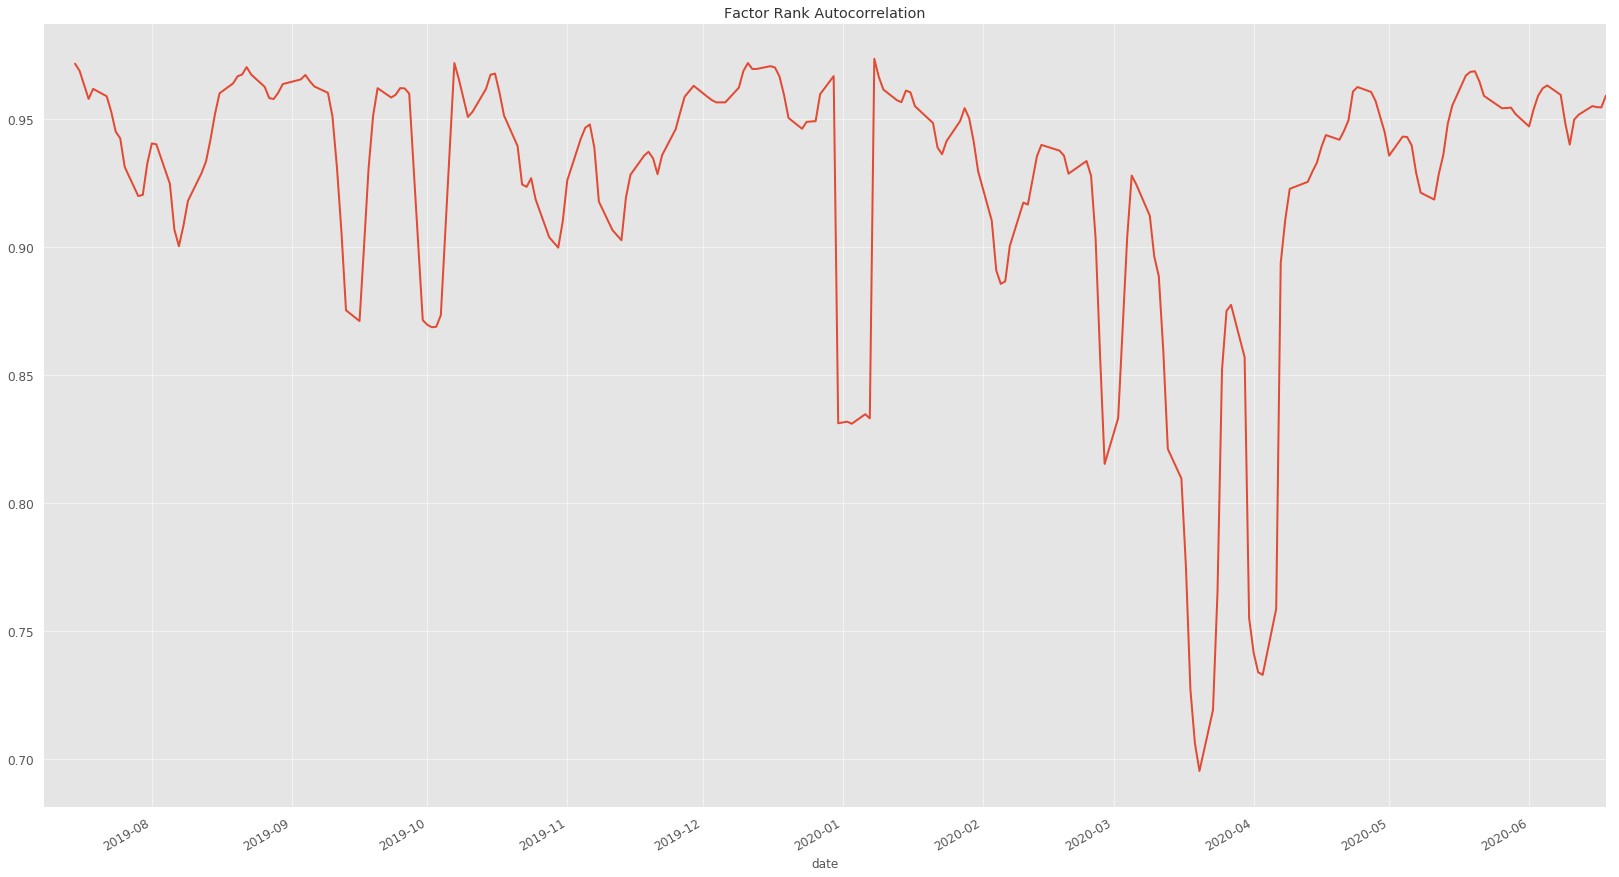

In [96]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [97]:
ls_FRA.mean()

0.9245965750347123

In [98]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

3D      4.99
5D      6.63
10D    10.53
dtype: float64

# 7 -  Risk Analysis for Equal Weights

In [99]:
assets = all_factors.index.levels[1]

In [100]:
all_weights = pd.DataFrame(np.repeat(1/len(assets), len(assets)), assets)

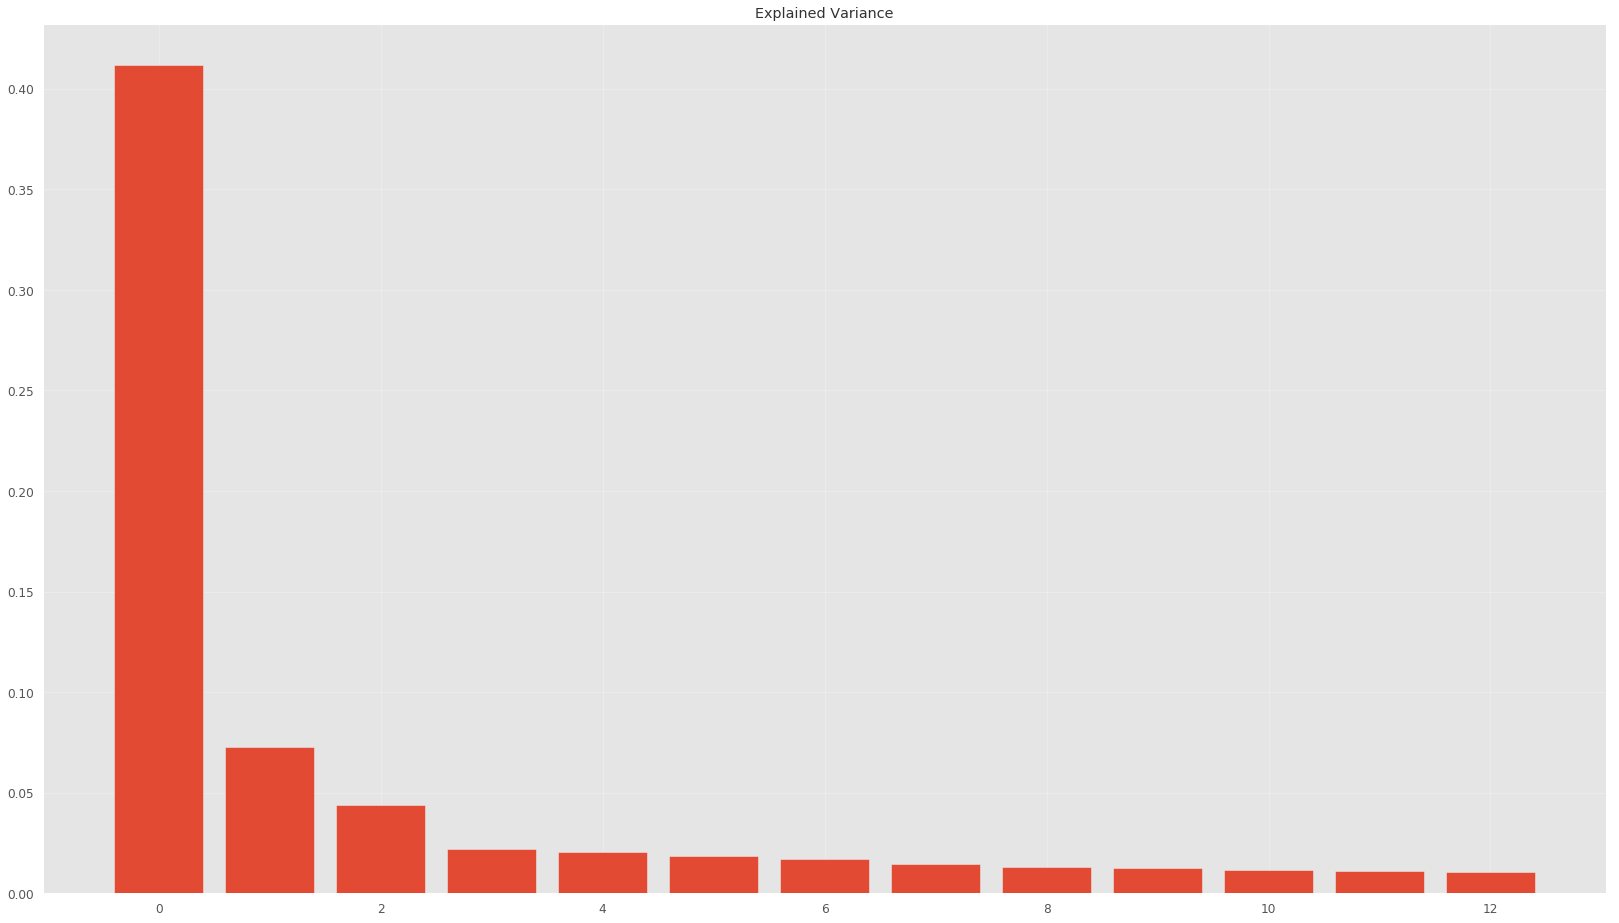

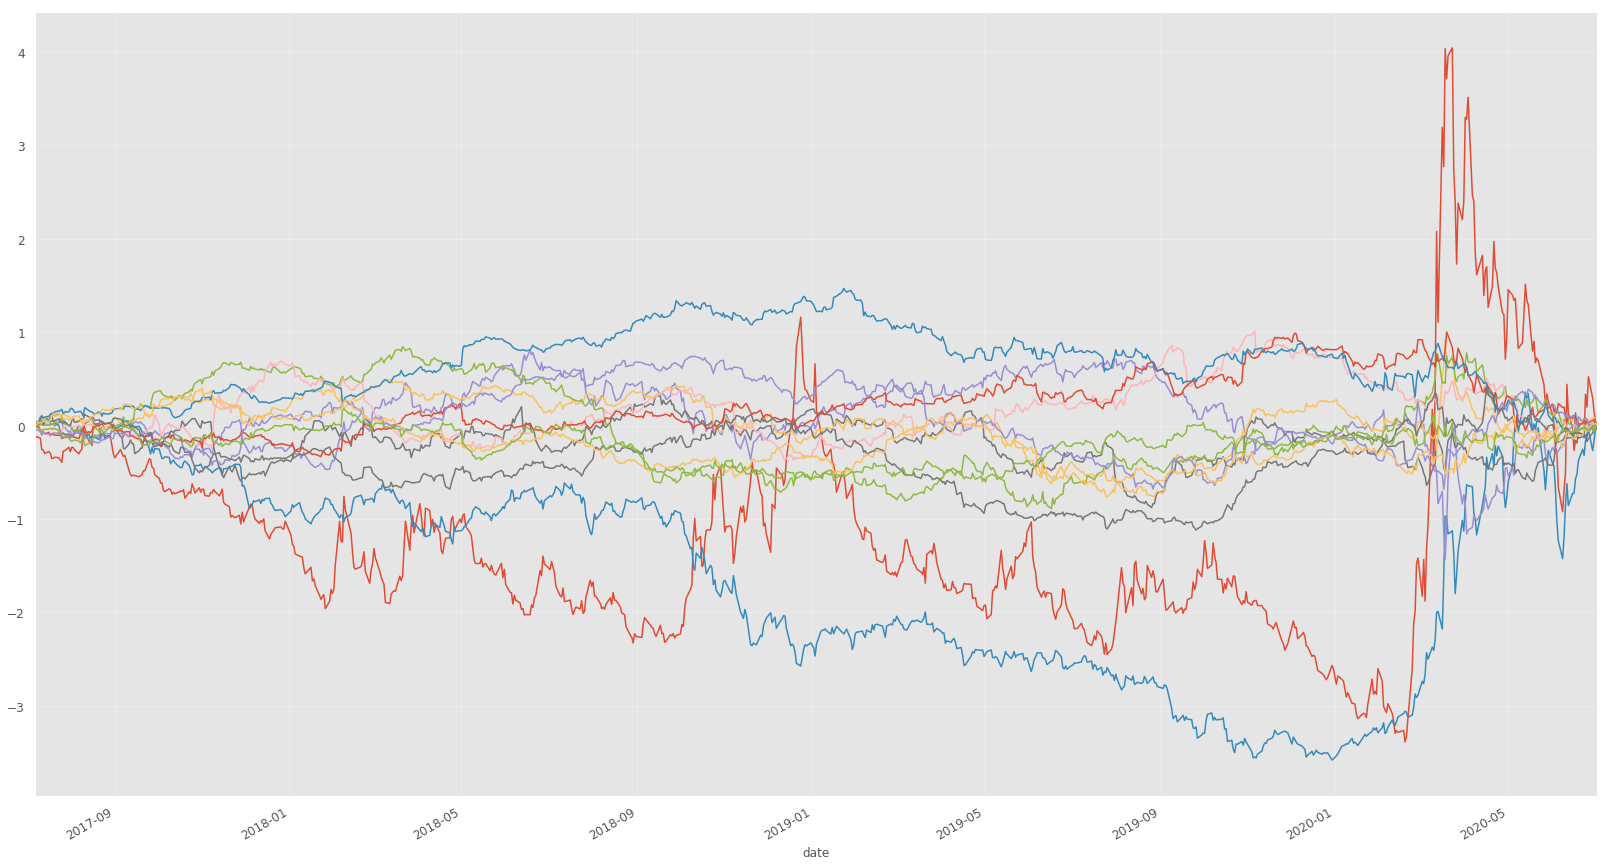

In [101]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[assets],num_factor_exposures=13,weights=all_weights)

In [102]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 24.5 %


# 9 - Integrating optimzer to factor data

In [103]:
optimal = pd.DataFrame(index = all_factors.index.levels[0], columns = all_factors.index.levels[1])
for date in all_factors.index.levels[0]:
    
    x = all_factors[['alpha_vector']].loc[date.date(),:]
    optimal.loc[date] = risk_model\
                          .OptimalHoldingsRegularization(lambda_reg = lambda_reg,
                                                         risk_cap = risk_cap).find(
                                                            x, 
                                                            Risk_Model['factor_betas'], 
                                                            Risk_Model['factor_cov_matrix'], 
                                                            Risk_Model['idiosyncratic_var_vector']).values.flatten()
    

    
optimal = optimal.astype(np.float)
optimal_stacked = optimal.stack().to_frame('optimal_weights')

In [137]:
assert optimal_stacked.shape[0] == vec.shape[0]

## Quantilize data

In [104]:
quantile_optimal_stacked = pd.DataFrame(index = optimal_stacked.index, 
                                        columns = ['optimal_weights','quantile','sector'])
labels = [i+1 for i in range(len(qunatile_portions)-1)]

for date in optimal_stacked.index.levels[0]:
    
    x = optimal_stacked['optimal_weights'].loc[date.date(),:]
    
    quantile_optimal_stacked.loc[date,'quantile'] = pd.qcut(x, qunatile_portions, 
                                                            labels = labels)
    
quantile_optimal_stacked.loc[:,'optimal_weights'] = optimal_stacked['optimal_weights']
quantile_optimal_stacked.loc[:,'sector'] = vec['sector']

In [140]:
quantile_optimal_stacked.shape

(43674, 3)

In [105]:
try:
    q_list = []
    for i in qunatile_to_analysis:
        q_list.append((quantile_optimal_stacked['quantile'] == i))

    df_merge = q_list[0]
    for df in q_list[1:]:       
        df_merge = df_merge ^ df
    
    q_final_vector = quantile_optimal_stacked[df_merge]
    
except:
    
    q_final_vector = quantile_optimal_stacked

In [106]:
remaining_quantiles = list(set(q_final_vector.loc[:,'quantile'].values))

In [139]:
q_final_vector.shape

(4518, 3)

## Sector Selection

In [108]:
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[-1]))

    for i in drop_short_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[0]))

    df_merge = drop_rows_list[0]
    for df in drop_rows_list[1:]:       
        df_merge = df_merge ^ df

    final_vector = q_final_vector[~df_merge]
    sectors = final_vector['sector']
    
    assert list(final_vector[(final_vector['quantile'] == labels[-1]) & (final_vector['sector'] == drop_long_sec[0])].values) == []
    assert list(final_vector[(final_vector['quantile'] == labels[0]) & (final_vector['sector'] == drop_short_sec[0])].values) == []

except:
    final_vector = q_final_vector
    sectors = final_vector['sector']

In [ ]:
final_vector.shape

## Balancing to long/short leverage target

In [17]:
percent_long_leverage_target = 0.6
percent_short_leverage_target = 0.4

In [19]:
for date in final_vector.index.levels[0]:
    
    long_balance = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0].sum().abs()[0]
    short_balance = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0].sum().abs()[0]
    
    long_ratio = percent_long_leverage_target / long_balance
    short_ratio = percent_short_leverage_target / short_balance

    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] * long_ratio
    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] * short_ratio

In [23]:
optimal_selected.abs().sum()[0]

1.0

## 9 - 2 - Creating clean factor data

In [110]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = q_final_vector['optimal_weights'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = len(remaining_quantiles),
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.20)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 20.0%, not exceeded: OK!


In [111]:
factor_data.shape

(4338, 6)

In [112]:
# Sector Selection
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == labels[-1]))

    for i in drop_short_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == labels[0]))

    df_merge = drop_rows_list[0]
    for df in drop_rows_list[1:]:       
        df_merge = df_merge ^ df

    factor_data = factor_data[~df_merge]
    sectors = factor_data['group']
    
    assert list(factor_data[(factor_data['factor_quantile'] == labels[-1]) & (factor_data['group'] == drop_long_sec[0])].values) == []
    assert list(factor_data[(factor_data['factor_quantile'] == labels[0]) & (factor_data['group'] == drop_short_sec[0])].values) == []

except:
    
    sectors = factor_data['group']

In [113]:
factor_data.shape

(4338, 6)

## 9 - 3 - Creating tear sheets 

In [143]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                   period= '{}D'.format(rebalance_period),
                                   capital=1,
                                   long_short=True,
                                   group_neutral=False,
                                   equal_weight=False,
                                   groups=sectors,
                                   #quantiles=[1,5],
                                   benchmark_period='{}D'.format(rebalance_period))

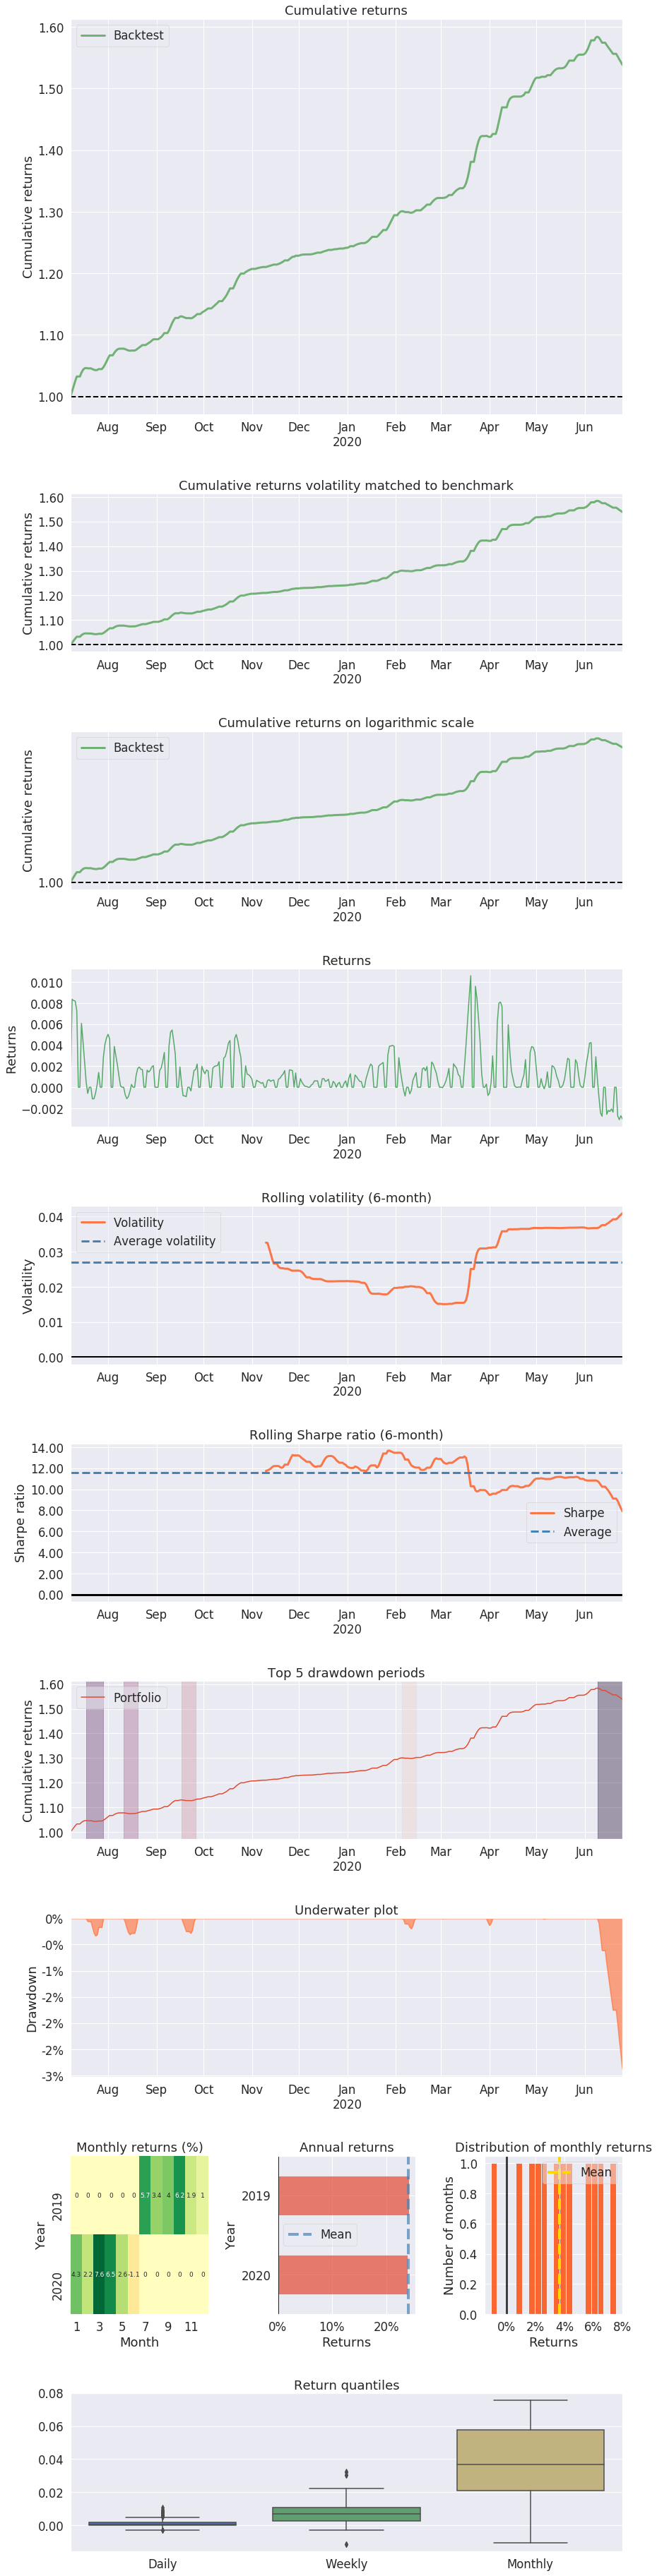

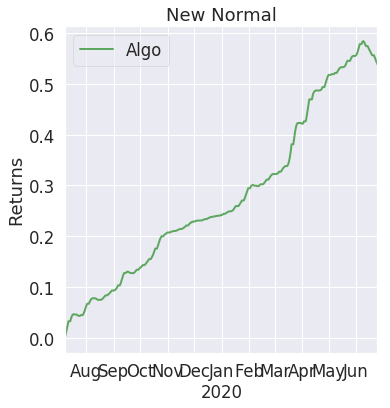

In [144]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.215169 -0.004928 -0.050828  0.038115   2169     50.0
2                0.004567  0.221217  0.047369  0.033863   2169     50.0

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.514    0.504    0.476
beta                                             0.106    0.104    0.048
Mean Period Wise Return Top Quantile (bps)      62.792   58.318   50.659
Mean Period Wise Return Bottom Quantile (bps)  -62.792  -58.546  -51.265
Mean Period Wise Spread (bps)                  125.583  116.876  101.949

<Figure size 2016x1152 with 0 Axes>

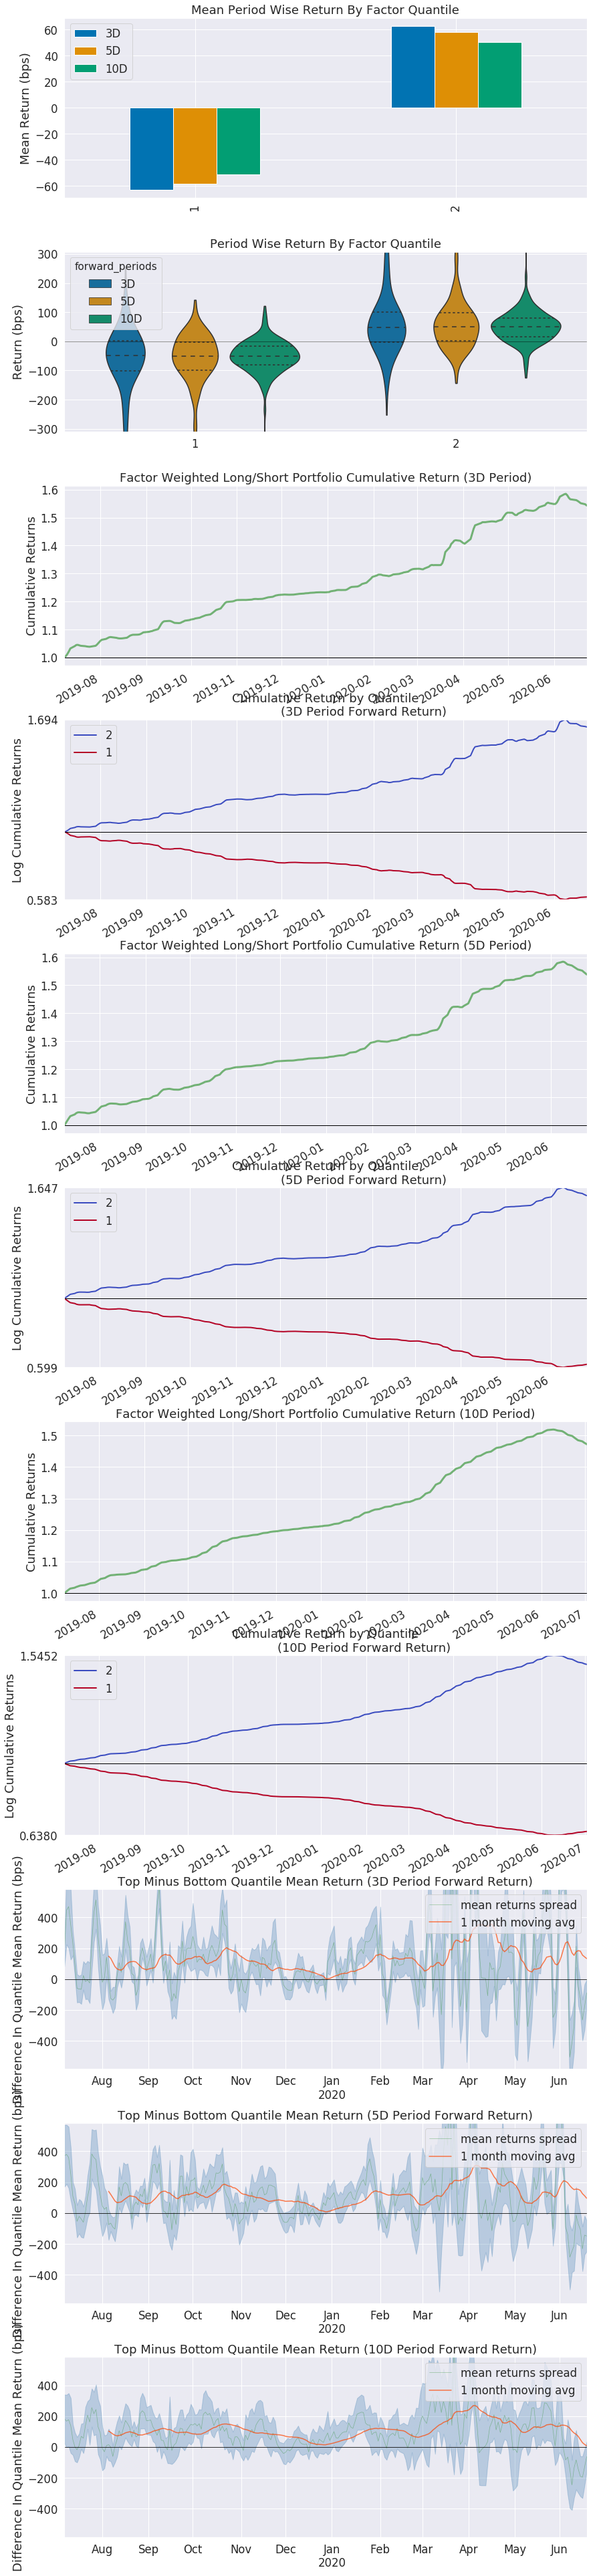

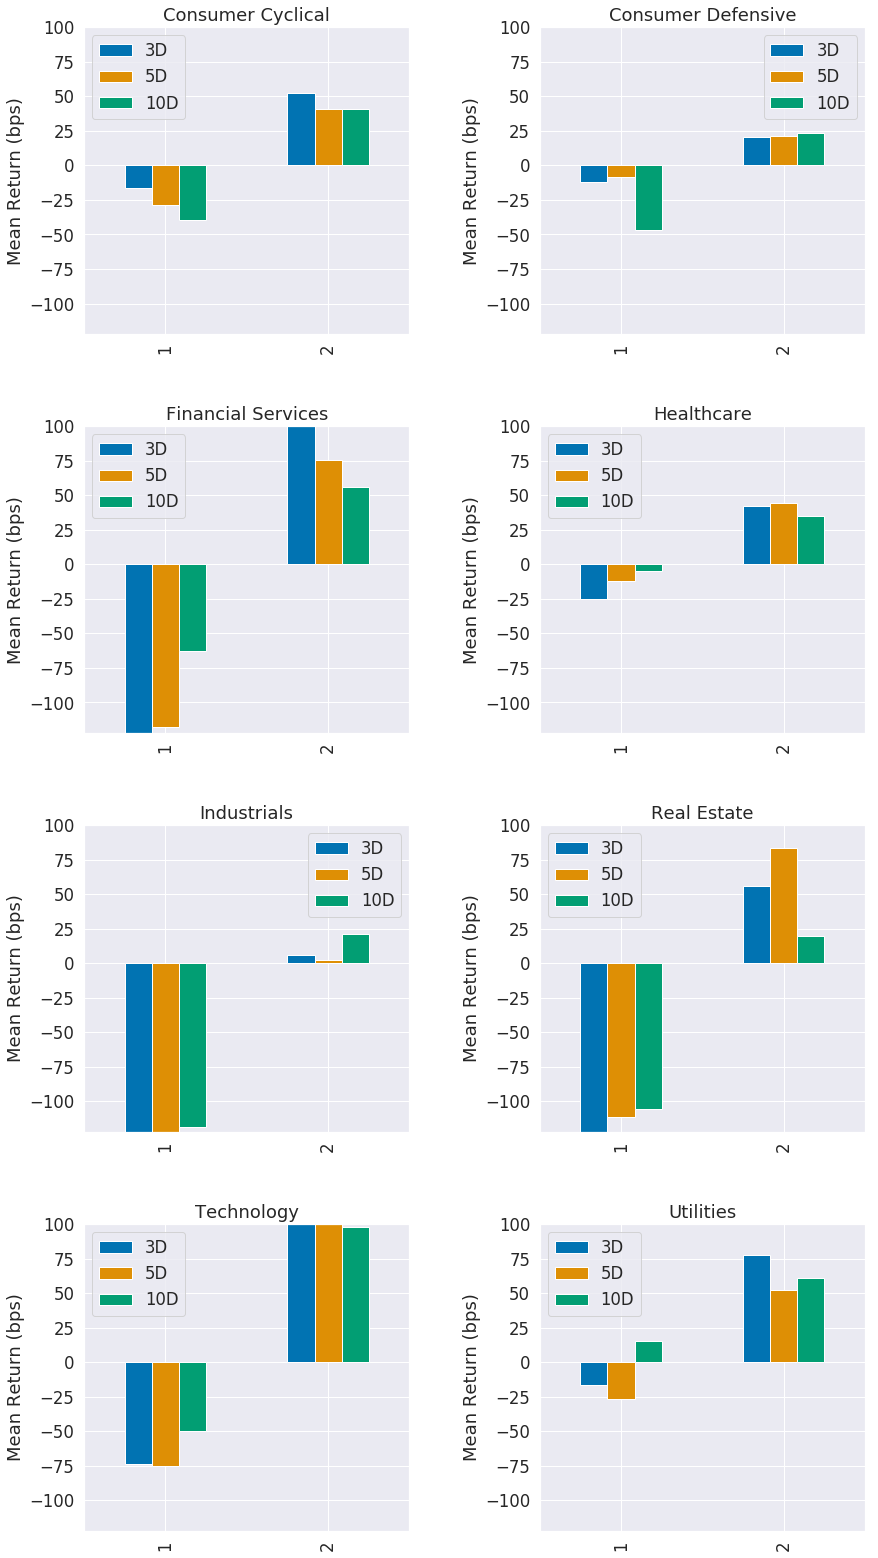

Information Analysis


3D     5D     10D
IC Mean           0.128  0.172   0.266
IC Std.           0.261  0.272   0.255
Risk-Adjusted IC  0.490  0.633   1.041
t-stat(IC)        7.605  9.823  16.159
p-value(IC)       0.000  0.000   0.000
IC Skew          -0.164 -0.267  -0.594
IC Kurtosis      -0.525 -0.521  -0.040

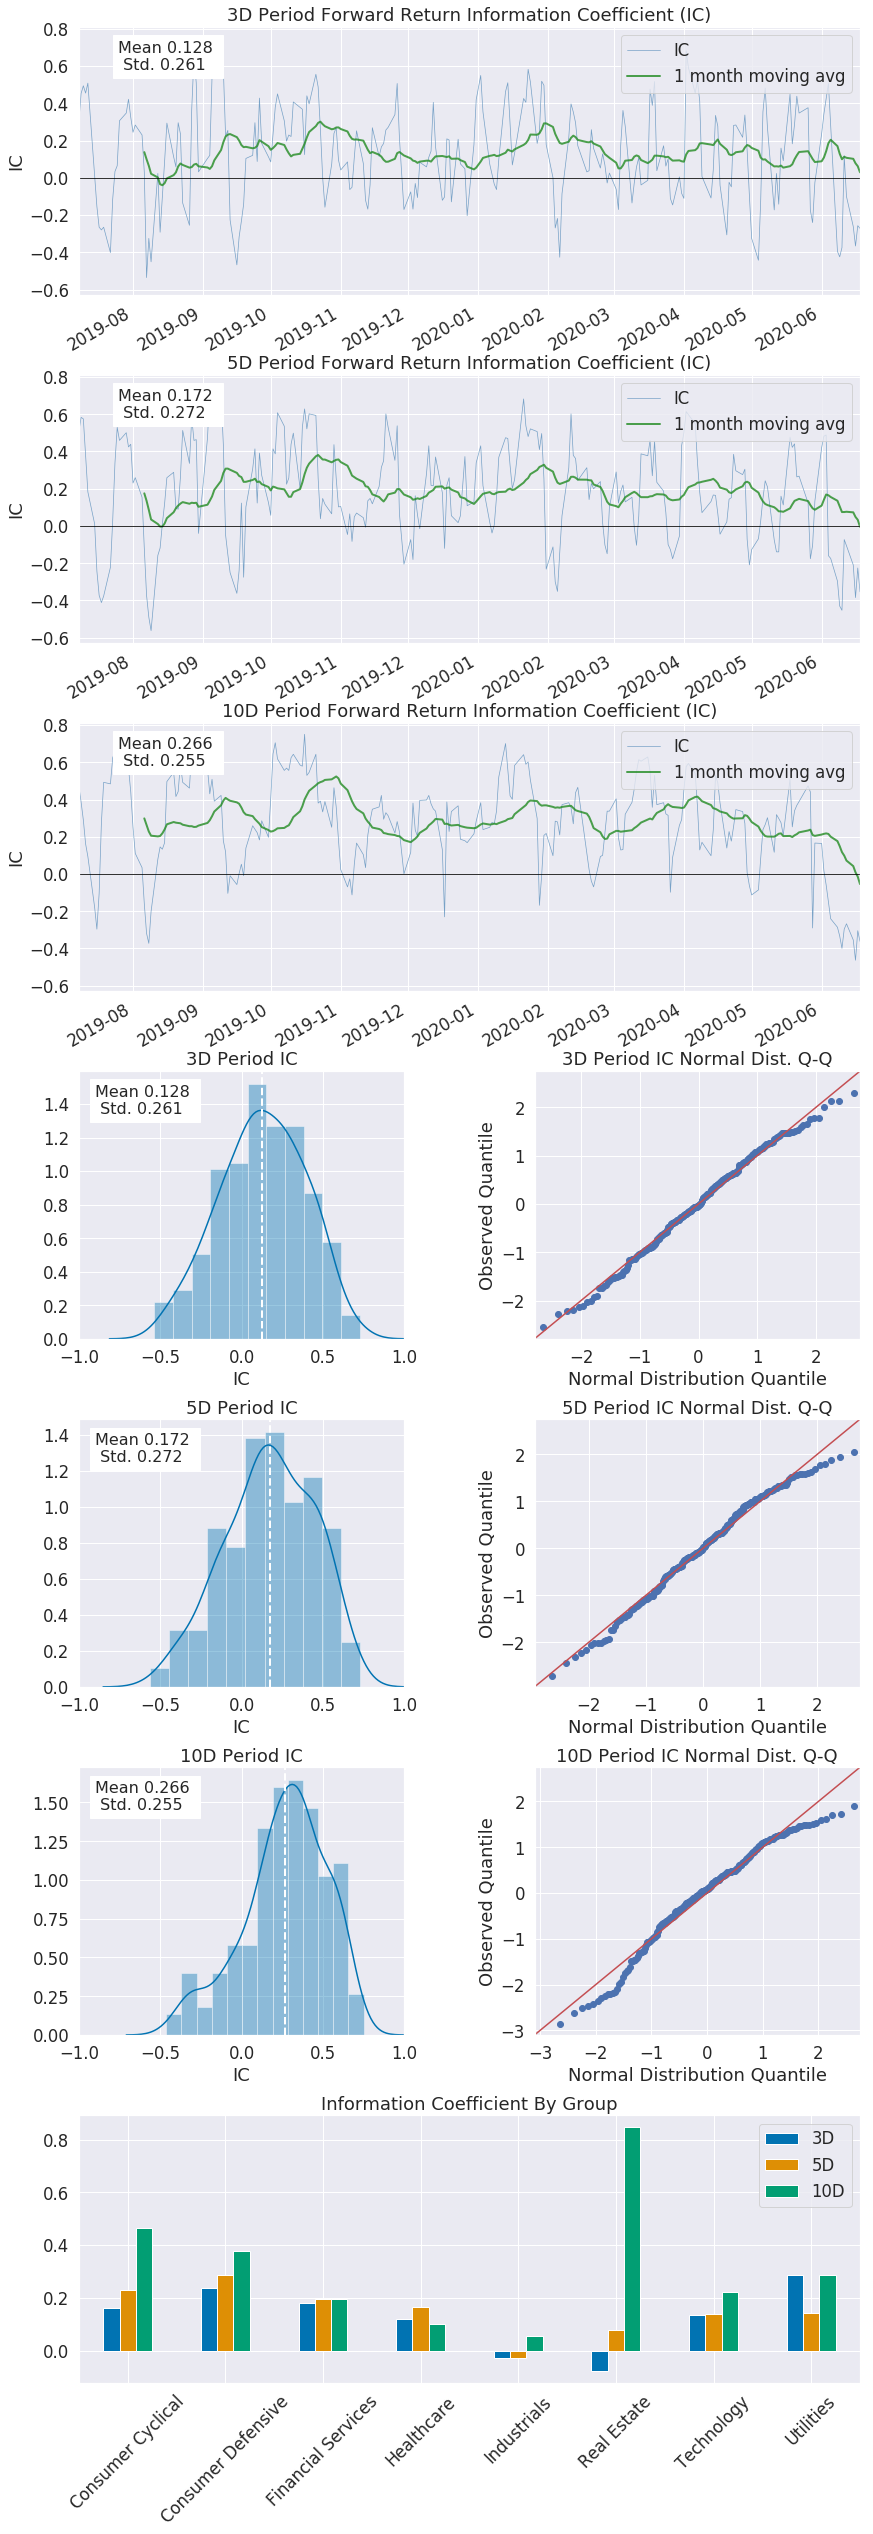

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover   0.464  0.223  0.321
Quantile 2 Mean Turnover   0.526  0.244  0.352

3D     5D    10D
Mean Factor Rank Autocorrelation  0.942  0.922  0.901

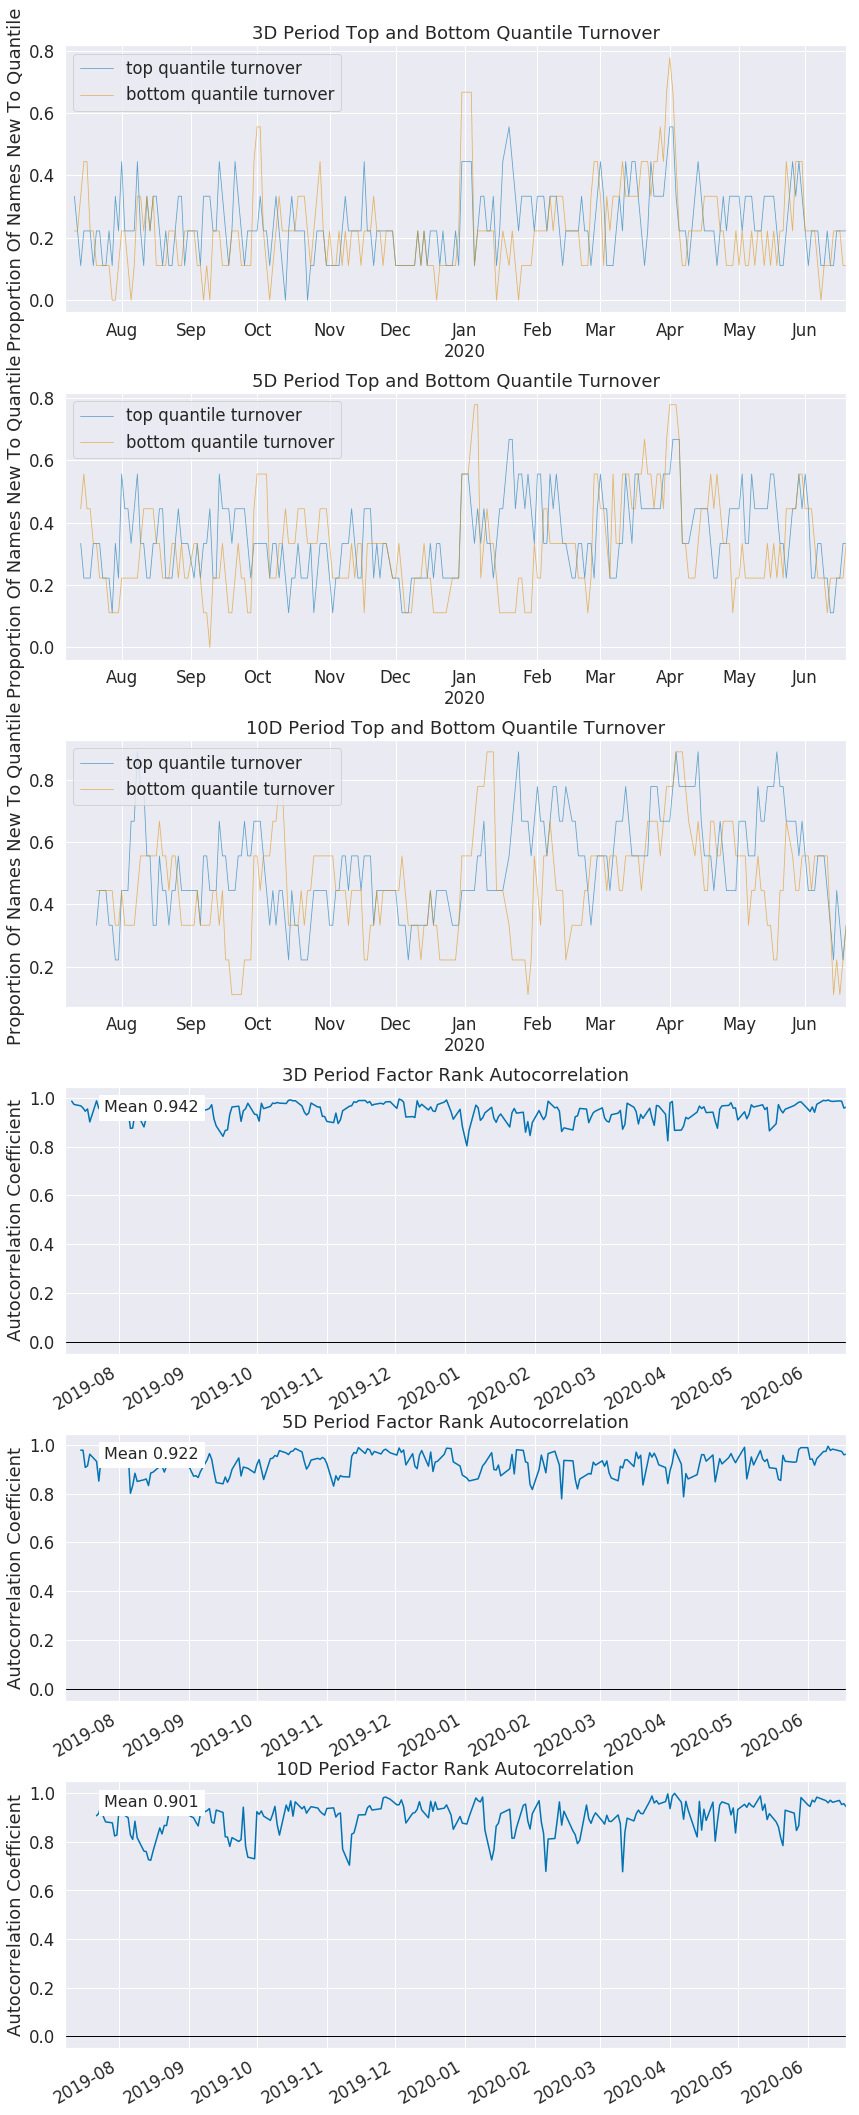

In [116]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

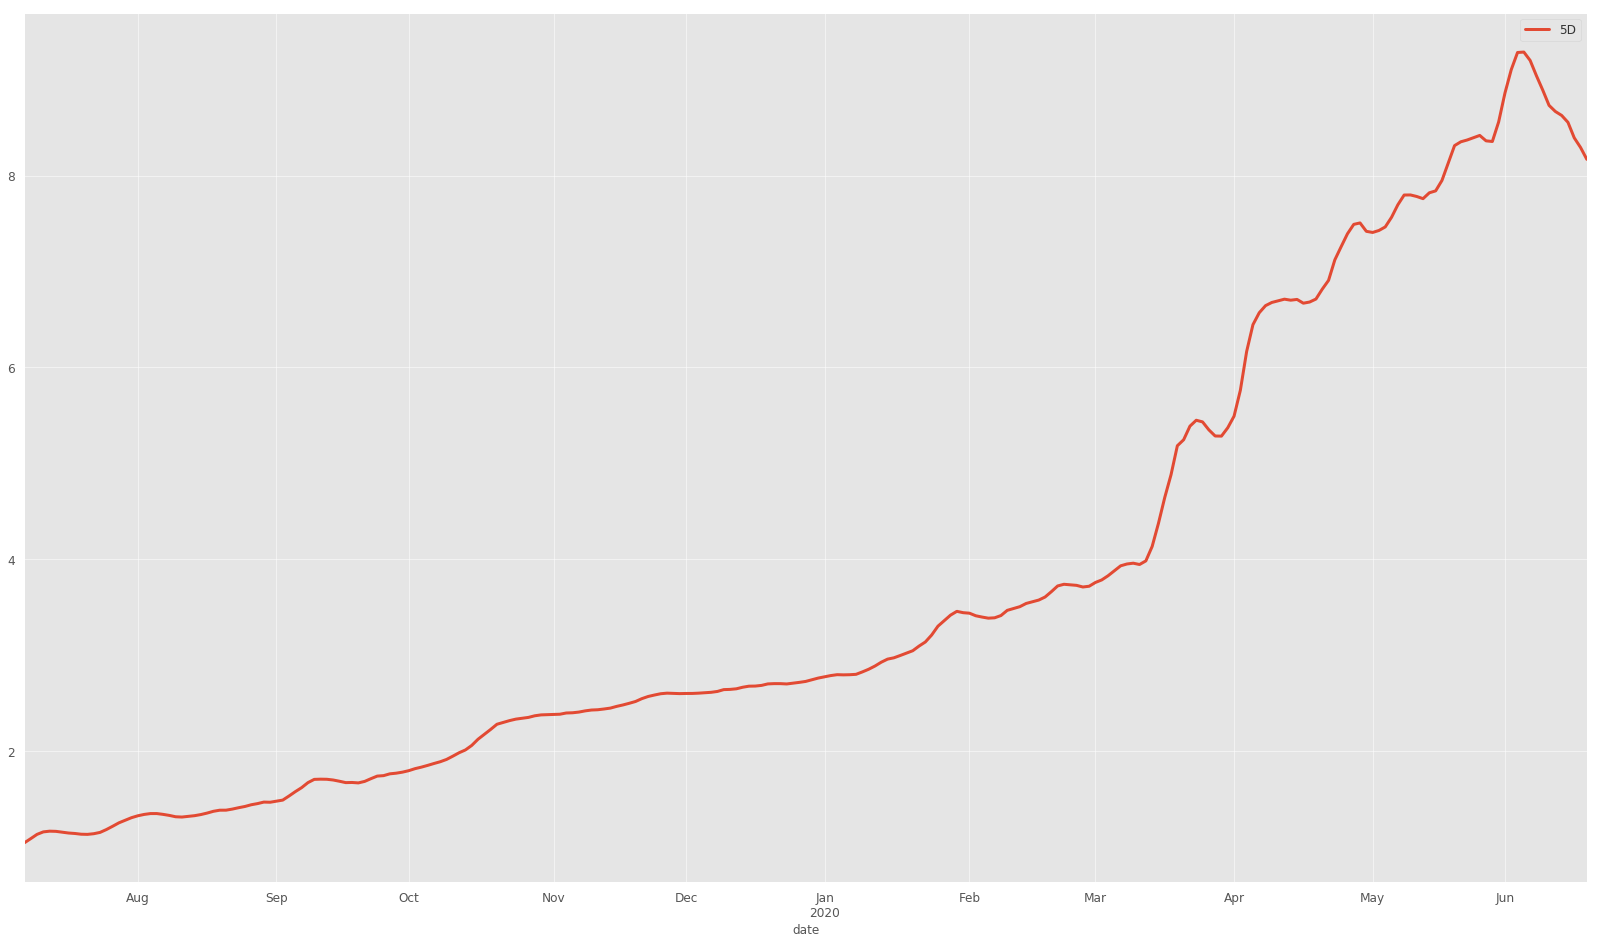

In [117]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data[['factor','5D']])

(1+ls_factor_returns).cumprod().plot(lw=3);

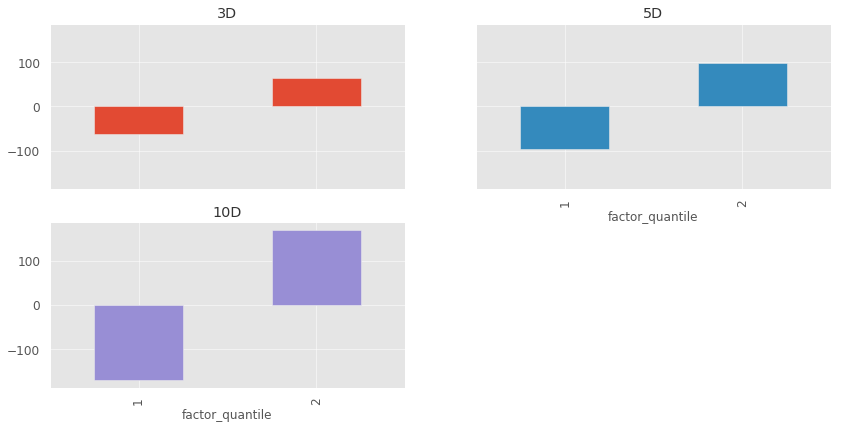

In [118]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

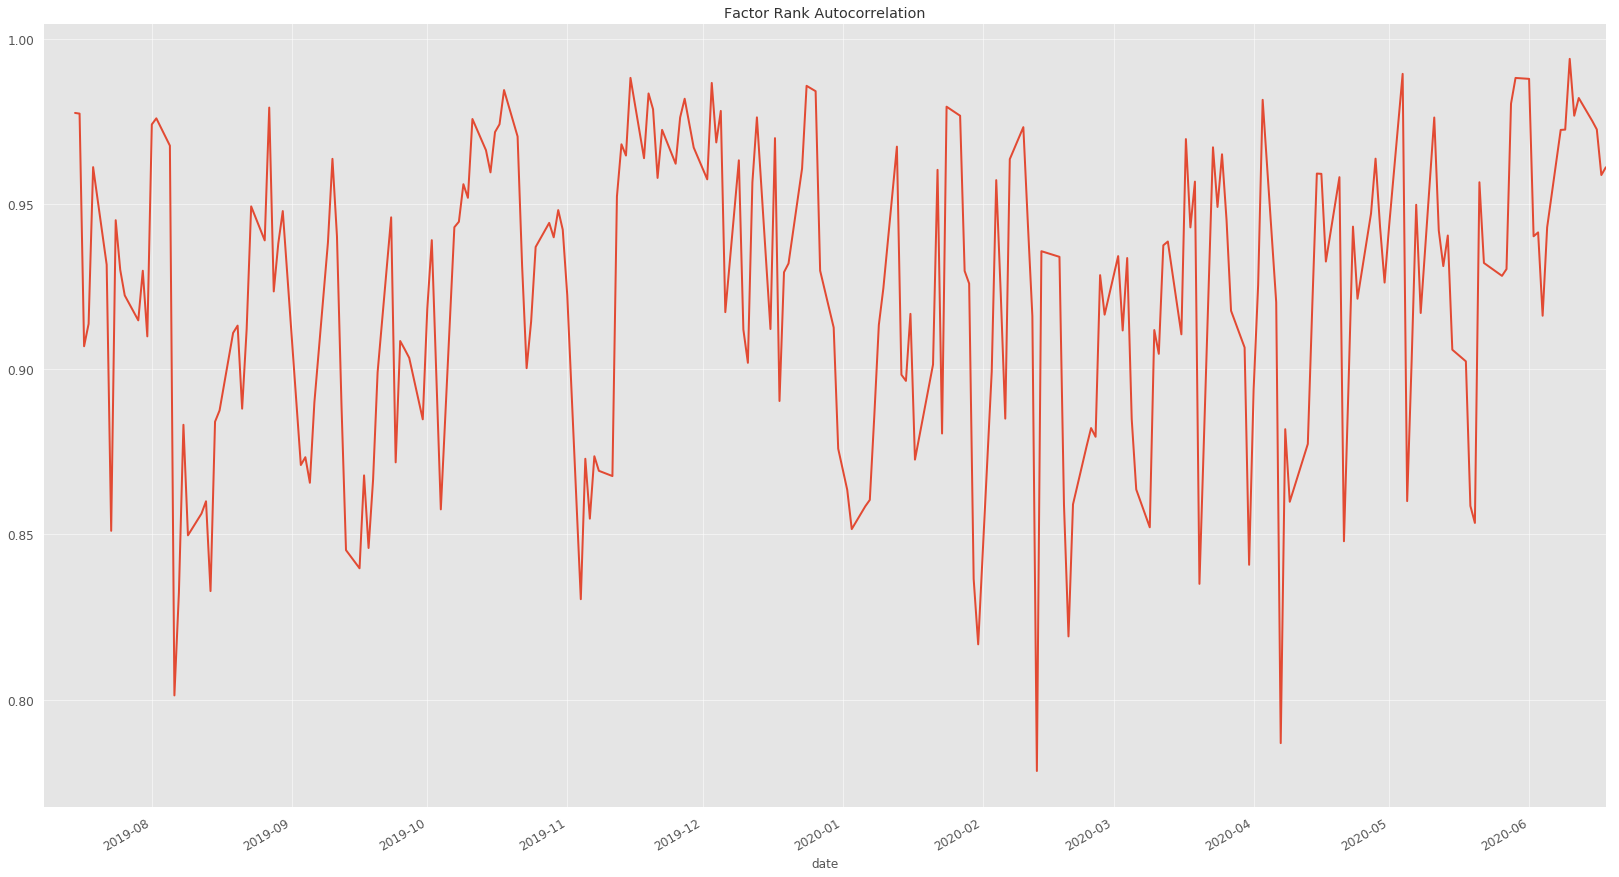

In [119]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [120]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

5D    10.17
dtype: float64

# 10 - Predicted Portfolio

In [121]:
optimal_weights_regularized = final_vector[['optimal_weights']].loc[final_vector.index.levels[0][-1]]

for 18 assets  with end date: 2020-07-02 00:00:00+00:00


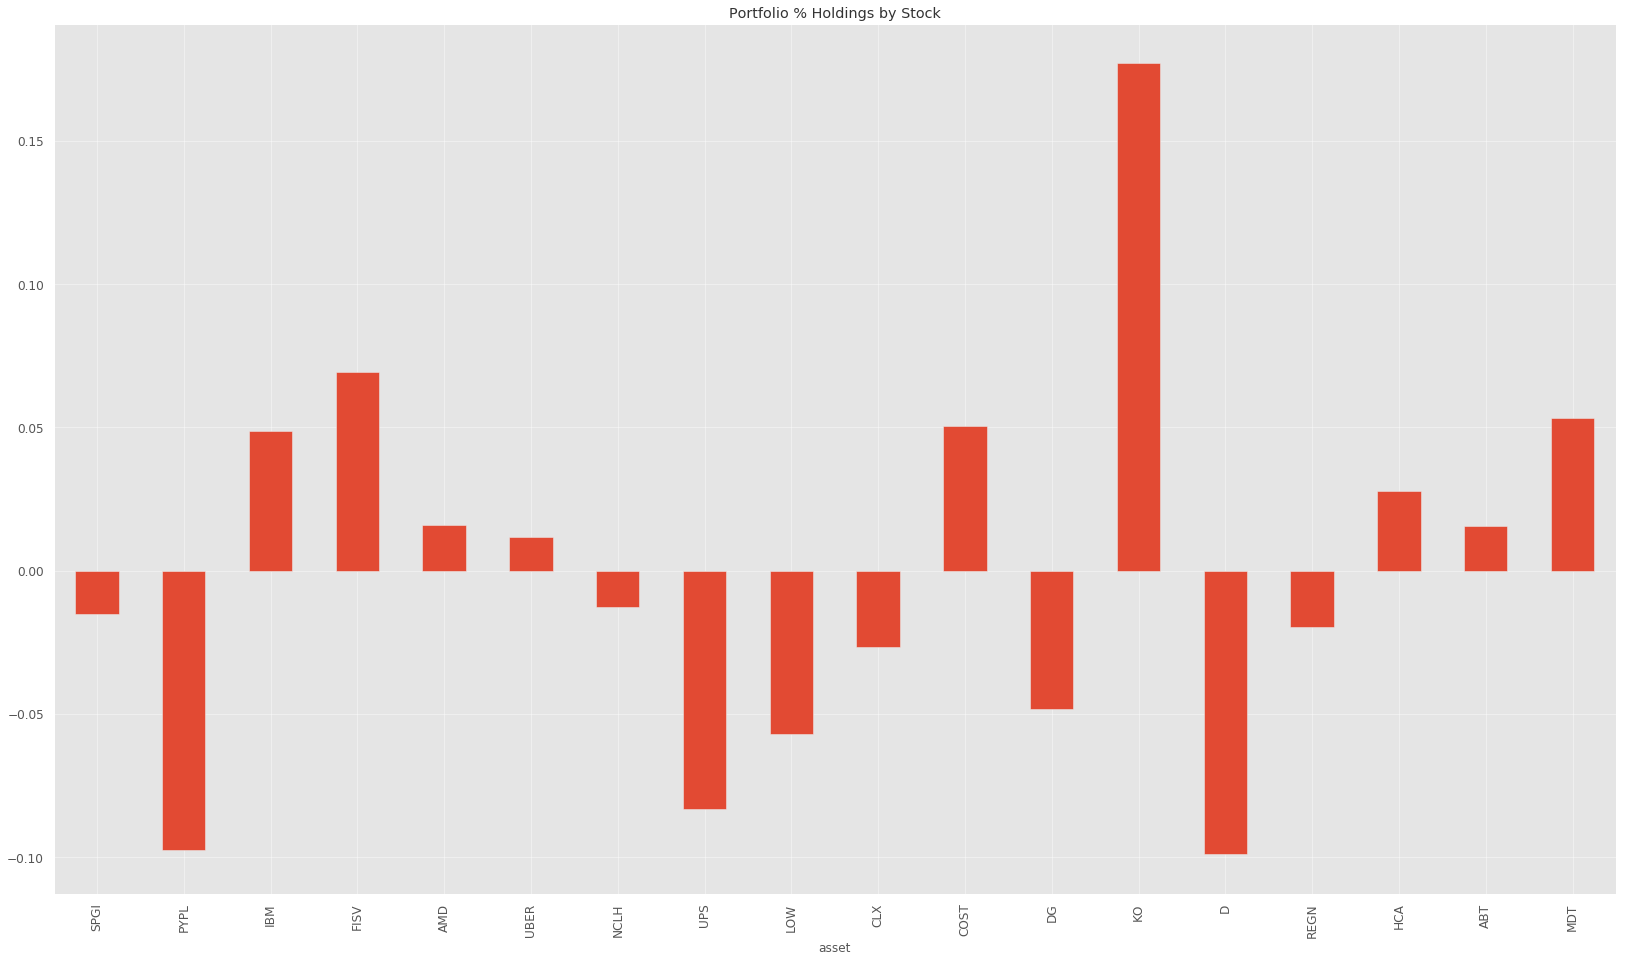

In [122]:
print ('for {} assets  with end date: {}'.format(len(optimal_weights_regularized.index),optimal.index[-1]))
optimal_weights_regularized.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.grid(alpha=0.8)

In [123]:
optimal_weights_regularized = pd.DataFrame(data = optimal_weights_regularized.values, 
                                           columns = ['optimal_weights'],
                                           index = optimal_weights_regularized.index)
optimal_weights_regularized.index.name = 'asset'

In [124]:
q5 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=False)[:len(optimal_weights_regularized.index)//5]
q1 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=True)[:len(optimal_weights_regularized.index)//5]

In [125]:
print (q5.iloc[0])
print (q1.iloc[0])

optimal_weights    0.177053
Name: KO, dtype: float64
optimal_weights   -0.098907
Name: D, dtype: float64


## 10 - 3 - Risk analysis with optimized weights

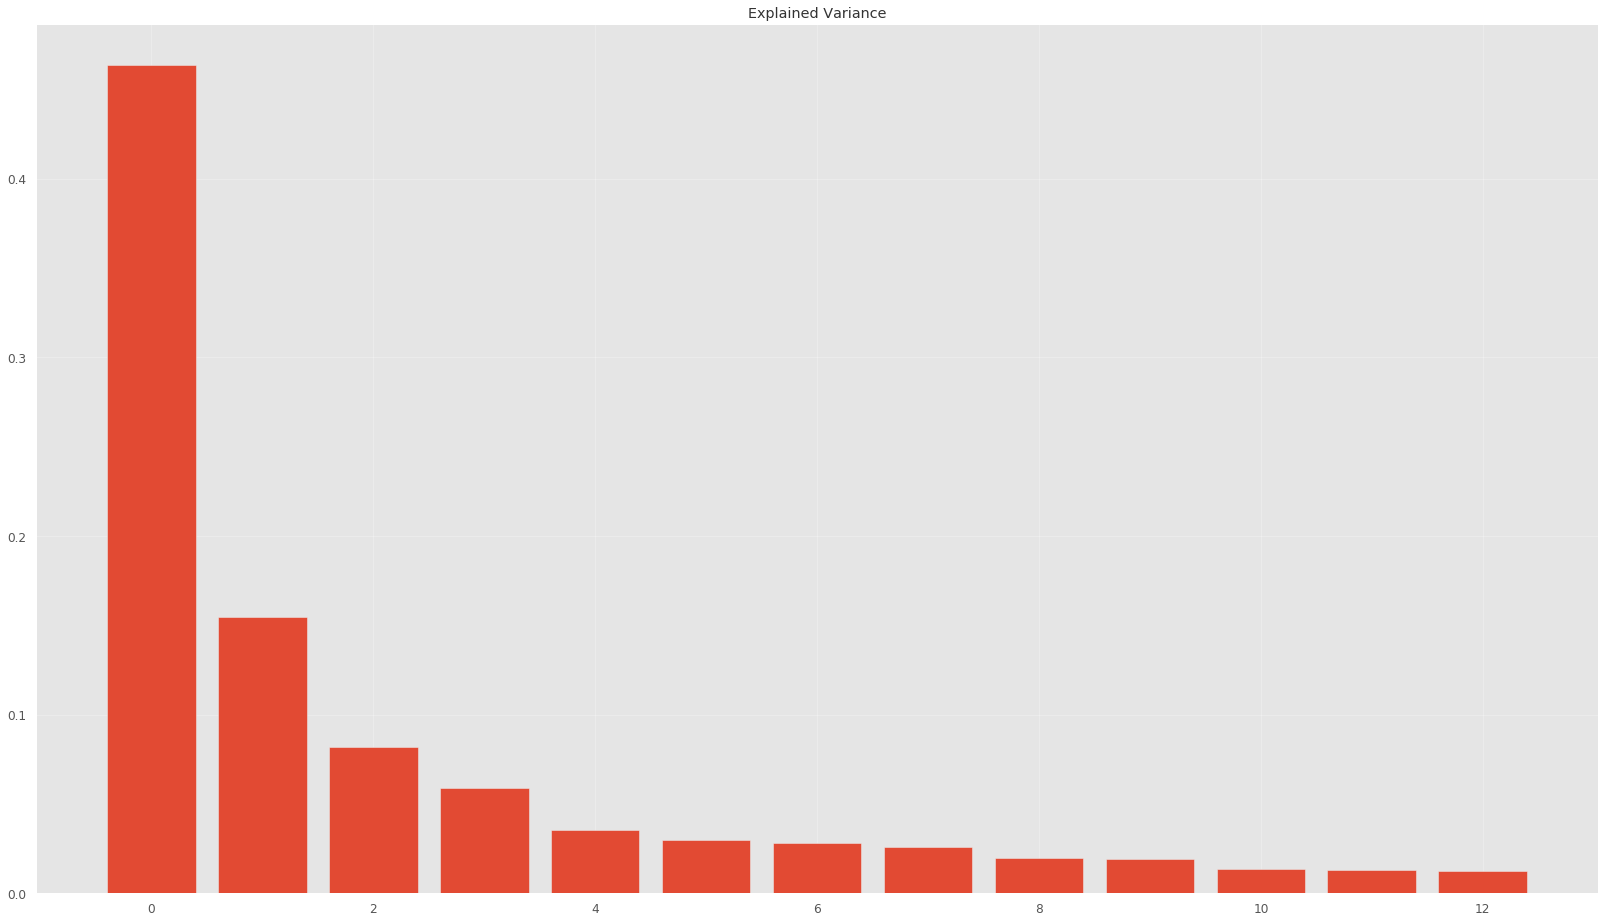

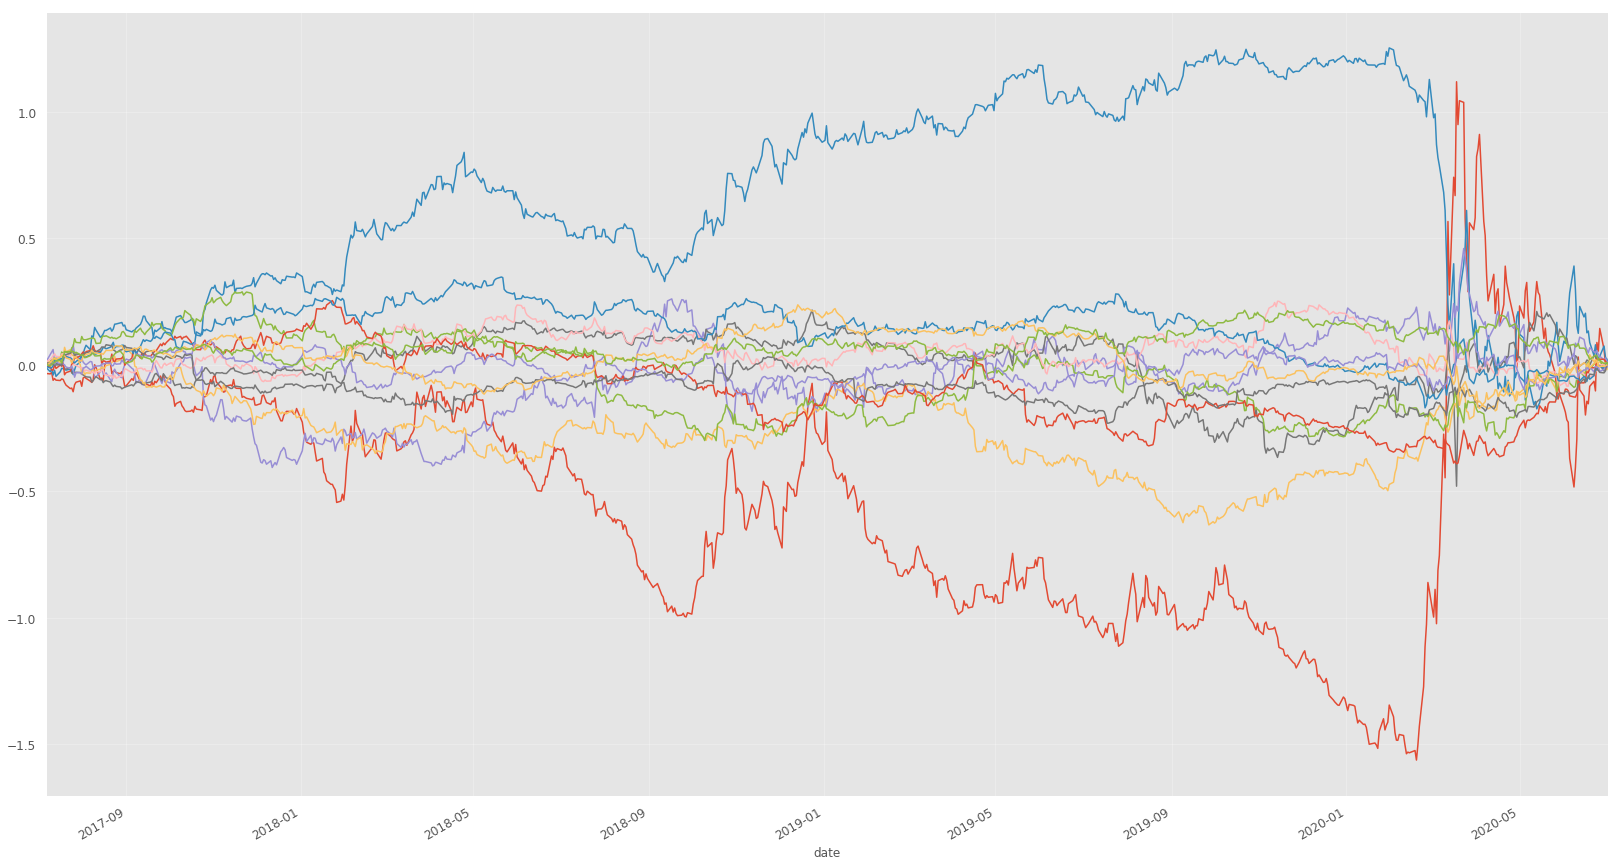

In [126]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[optimal_weights_regularized.index],num_factor_exposures=factor_exposures,weights=optimal_weights_regularized)

In [127]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 5.25 %


In [128]:
all_factors.to_csv('all_factors.csv')
optimal_weights_regularized.to_csv('optimal_weights_regularized.csv')
close.to_csv('close.csv')

In [129]:
optimal_weights_regularized.sort_values(by='optimal_weights').tail()

optimal_weights
asset                 
IBM           0.048774
COST          0.050533
MDT           0.053183
FISV          0.069200
KO            0.177053

In [130]:
pf_positions.loc[pf_positions.index[0]].sort_values().tail(10)

asset
UNH     0.031691
RNG     0.034572
DOCU    0.037551
VRTX    0.039602
NVDA    0.045982
SCHW    0.047851
BMY     0.055775
KR      0.060787
HUM     0.146189
cash    1.000000
Name: 2019-07-08 00:00:00+00:00, dtype: float64

In [131]:
pf_positions.index[0]

Timestamp('2019-07-08 00:00:00+0000', tz='UTC', freq='D')

In [147]:
import vlc
p = vlc.MediaPlayer("/home/k13104/Desktop/ES_PREL Whoosh Soft 7 - SFX Producer.mp3")
p.play()

0